In [1]:
from tqdm import tqdm
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten, Dropout, BatchNormalization, MaxPool2D, Activation, AveragePooling2D
from keras.layers import ZeroPadding2D

from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import EarlyStopping
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

import math
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['text.usetex'] = True


In [ ]:
cd ..

In [3]:
from model.model_funcs import *

In [ ]:
cd notebooks

## Define our models

In [5]:
def load_mnist():
    (trainX, trainY), (testX, testY) = mnist.load_data()
    
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    
    cutoff = 50000
    
    trainX_ = trainX[:cutoff]
    trainY_ = trainY[:cutoff]
    
    valX = trainX[cutoff:]
    valY = trainY[cutoff:]
    
    return trainX_, trainY_, valX, valY, testX, testY
    

def load_cifar10():
    (trainX, trainY), (testX, testY) = cifar10.load_data()

    trainX = trainX.reshape((trainX.shape[0], 32, 32, 3))
    testX = testX.reshape((testX.shape[0], 32, 32, 3))
    
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    
    return trainX, trainY, testX, testY


def norm_(train, val, test):
    return train.astype('float32') / 255.0, val.astype('float32') / 255.0, test.astype('float32') / 255.0

def norm(data):
    return data.astype('float32') / 255.0

def square_activation(x):
    return K.square(x)

def identity(x):
    return x

In [45]:
def mnist_cryptonets_original(activation=square_activation):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1), input_shape=(28, 28, 1)))
    model.add(Conv2D(5, (5, 5), strides=2, padding='valid'))
    model.add(Activation(activation))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=1, padding='same'))
    model.add(Conv2D(50, (5, 5), strides=2, padding='valid'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=1, padding='same'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation(activation))
    model.add(Dense(10, activation='sigmoid'))

    opt = Adam(lr=0.0005)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def mnist_cryptonets(activation=square_activation):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1), input_shape=(28, 28, 1)))
    model.add(Conv2D(5, (5, 5), strides=2, padding='valid'))
    model.add(Activation(activation))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation(activation))
    model.add(Dense(10, activation='softmax'))

    opt = Adam(lr=0.0005)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def mnist_tiny():
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(5, (5, 5), strides=2, padding='valid'))
    model.add(Activation(activation))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=1, padding='same'))
    model.add(Conv2D(50, (5, 5), strides=2, padding='valid'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=1, padding='same'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation(activation))
    model.add(Dense(10, activation='softmax'))

    opt = SGD(lr=0.0005)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def mnist_opt(activation=square_activation):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1), input_shape=(28, 28, 1)))
    model.add(Conv2D(5, (3, 3), strides=1, padding='valid'))
    model.add(Activation(activation))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=2, padding='same'))
    model.add(Conv2D(50, (3, 3), strides=1, padding='valid'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=1, padding='same'))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Activation(activation))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    opt = Adam(lr=0.00004)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def mnist_opt_bn(activation=square_activation):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1), input_shape=(28, 28, 1)))
    model.add(Conv2D(5, (3, 3), strides=1, padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=2, padding='same'))
    model.add(Conv2D(50, (3, 3), strides=1, padding='valid'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=1, padding='same'))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dense(10, activation='softmax'))

    opt = Adam(lr=0.00004)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def cifar(activation=square_activation):
    model = Sequential()
    model.add(Conv2D(18, kernel_size=(3, 3), strides=1, input_shape=(32, 32, 3)))
    model.add(Activation(activation))

    model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=1))
    model.add(Dropout(0.3))
    model.add(Activation(activation))
    
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=1))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation(activation))

    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))

    opt = Adam(lr=0.0008)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def cifar_bn(activation=square_activation):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=1, input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=1))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=1))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def cifar_():
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Conv2D(83, kernel_size=(3, 3), strides=1, padding='valid'))
    model.add(Activation(square_activation))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Dropout(0.2))

    model.add(Conv2D(163, kernel_size=(3, 3), strides=1, padding='valid'))
    model.add(Activation(square_activation))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation(square_activation))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    opt = Adam(lr=0.0002)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Original CryptoNets model

#### Train model

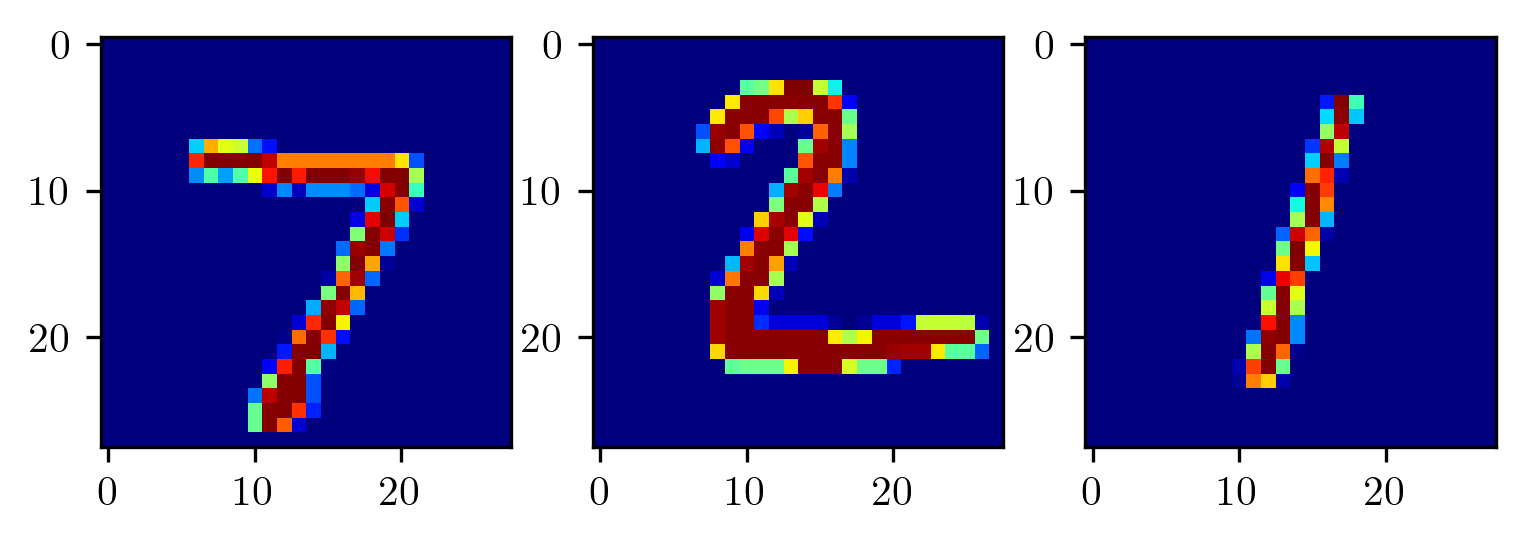

In [50]:
trainX, trainY, valX, valY, testX, testY = load_mnist()
trainX, valX, testX = norm_(trainX, valX, testX)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(testX[0], cmap='jet')
ax[1].imshow(testX[1], cmap='jet')
ax[2].imshow(testX[2], cmap='jet')

In [51]:
model1 = mnist_cryptonets_original(square_activation)
weights_start = model1.get_weights()

callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=6)

model1.fit(
    trainX, trainY,
    epochs=80,
    validation_data=(valX, valY),
    workers=6,
    batch_size=32,
    callbacks=[callback]
)

model1.summary()


Epoch 1/80
1563/1563 [==============================] - 3s 2ms/step - loss: 0.7793 - accuracy: 0.7605 - val_loss: 0.1787 - val_accuracy: 0.9497
Epoch 2/80
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1779 - accuracy: 0.9470 - val_loss: 0.1239 - val_accuracy: 0.9668
Epoch 3/80
1563/1563 [==============================] - 3s 2ms/step - loss: 0.1136 - accuracy: 0.9662 - val_loss: 0.1040 - val_accuracy: 0.9713
Epoch 4/80
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0909 - accuracy: 0.9735 - val_loss: 0.0856 - val_accuracy: 0.9740
Epoch 5/80
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0826 - accuracy: 0.9753 - val_loss: 0.0810 - val_accuracy: 0.9758
Epoch 6/80
1563/1563 [==============================] - 4s 2ms/step - loss: 0.0667 - accuracy: 0.9799 - val_loss: 0.0742 - val_accuracy: 0.9771
Epoch 7/80
1563/1563 [==============================] - 3s 2ms/step - loss: 0.0564 - accuracy: 0.9832 - val_loss: 0.0730 - val_accuracy:

In [52]:
model1.evaluate(testX, testY)

313/313 [==============================] - 0s 1ms/step - loss: 0.0563 - accuracy: 0.9830


[0.056305259466171265, 0.9829999804496765]

#### Combine linear layers

In [12]:
W_conv = model1.layers[4].weights[0]
W_conv = np.transpose(W_conv, (3, 2, 0, 1))
W_conv_biases = model1.layers[4].weights[1]

M_1 = conv_weights(d_in=13, W_c=avg_pool_weights(c_in=5, k=3), s=1, padding='same', pool=True)
M_2 = conv_weights(d_in=13, W_c=W_conv, s=2, padding='valid')
M_3 = conv_weights(d_in=5, W_c=avg_pool_weights(c_in=50, k=3), s=1, padding='same', pool=True)
M_4 = dense_weights(model1.layers[7].weights[0].numpy(), 50).transpose()

b_2 = conv_biases(d_in=13, W_c=W_conv, biases=W_conv_biases, s=2, padding='valid')
b_4 = model1.layers[7].weights[1].numpy()

100%|██████████| 1250/1250 [00:00<00:00, 2896.86it/s]


In [13]:
M = np.matmul(M_2, M_1)
M = np.matmul(M_3, M)
M = np.matmul(M_4, M)

In [14]:
b = np.matmul(M_4, np.matmul(M_3, b_2)) + b_4
b.shape
M.shape


(100, 845)

In [15]:
save_data(model1, 'MNIST-CRYPTONETS-ORIGINAL', testX, linear=[(M.transpose(), b, 3, 8)])

(3, 2)


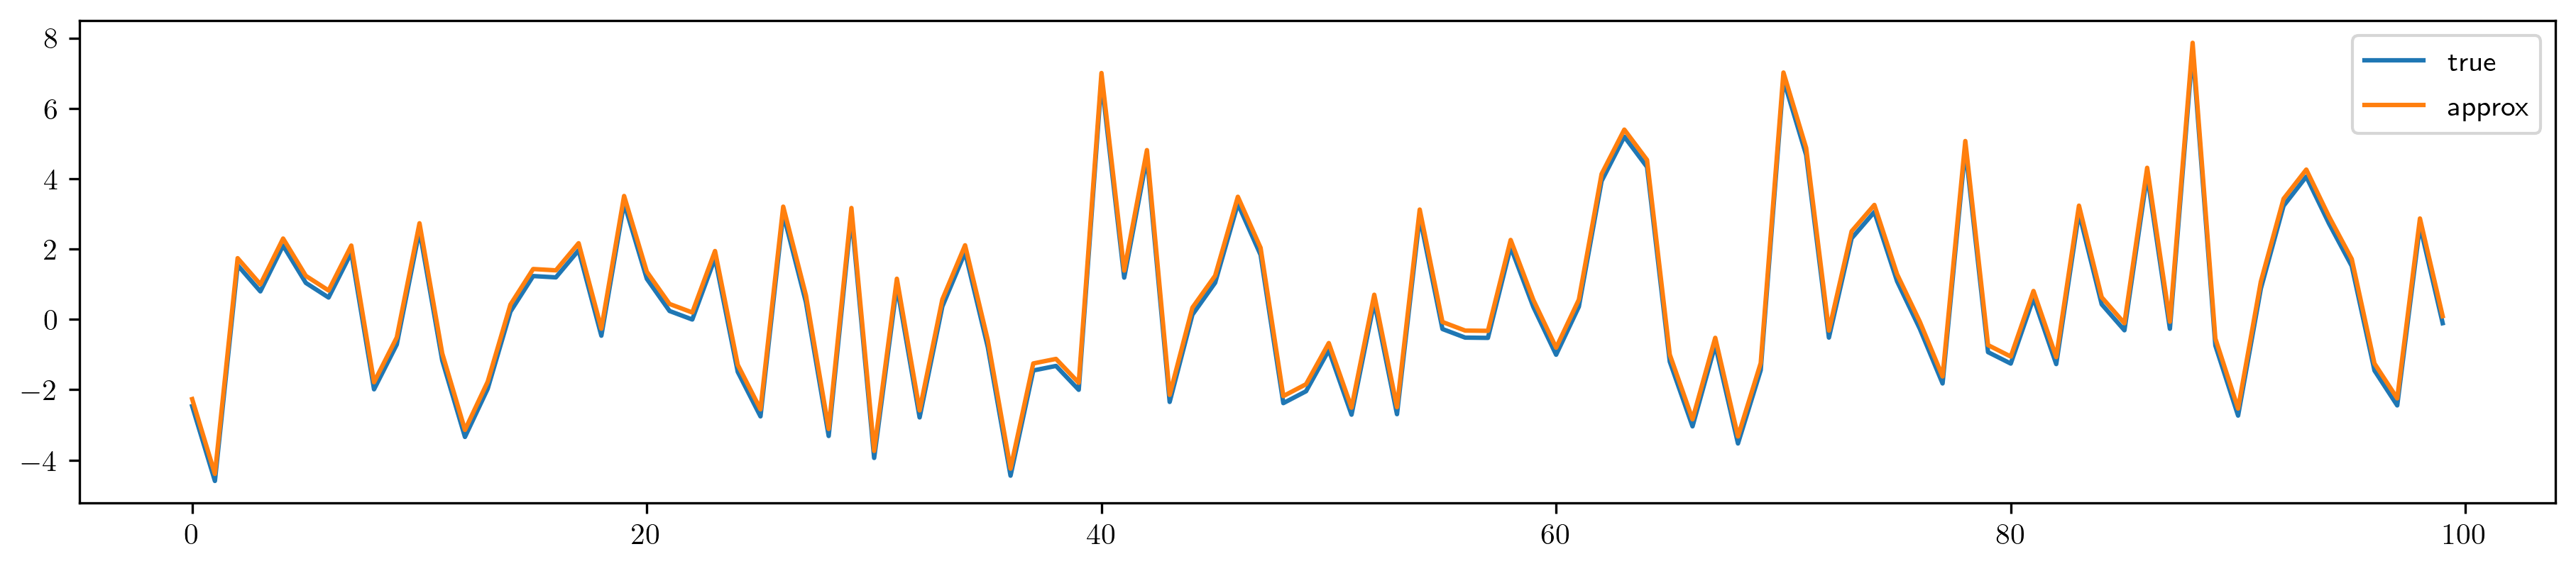

In [16]:
image = np.random.uniform(-1, 1, (1, 13, 13, 5))

ref = model1.layers[7](model1.layers[6](model1.layers[5](model1.layers[4](model1.layers[3](image))))).numpy()[0]
test = np.matmul(M, np.transpose(image, (0, 3, 1, 2)).flatten()) +b


plt.figure(figsize=(15, 3))
plt.plot(ref, label='true')
plt.plot(test + .2, label='approx')
plt.legend()
plt.show()

#### Lottery pruning

In [25]:
model1 = tf.keras.models.load_model('saved_model/MNIST-CRYPTONETS')
model1.evaluate(testX, testY)

313/313 [==============================] - 0s 1ms/step - loss: 0.1648 - accuracy: 0.9843


[0.16478553414344788, 0.9843000173568726]

In [33]:
import lottery_ticket_pruner

pruner = lottery_ticket_pruner.LotteryTicketPruner(model1)

def fit_pruned(model, pruner, trainX, trainY, testX, testY, batch_size, epochs):
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)]
    if pruner is not None:
        callbacks += [lottery_ticket_pruner.PrunerCallback(pruner, use_dwr=False)]
    model.fit(trainX, trainY,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(testX, testY),
              callbacks=callbacks
    )
    
pruner.set_pretrained_weights(model1)
rate_total = 0.0
n = 100

In [34]:
accs = []
losses = []
accs_train = []
losses_train = []
rates = []

r = 1 - math.pow(0.1, 1 / n)

In [35]:
for i in range(n):
    rate_total += (1.0 - rate_total) * r

    pruner.calc_prune_mask(model1, r, 'smallest_weights_global')
    
    pruned = mnist_cryptonets(square_activation)
    pruned.set_weights(weights_start)   
    fit_pruned(pruned, pruner, trainX, trainY, valX, valY, batch_size=64, epochs=300)
    
    pruned.save('saved_model/pruned' + str(rate_total * 100)[:4])
    
    a, b = pruned.evaluate(valX, valY)
    accs.append(b)
    losses.append(a)
    
    a, b = pruned.evaluate(trainX, trainY)
    accs_train.append(b)
    losses_train.append(a)
    
    rates.append(rate_total)

Epoch 1/300
782/782 [==============================] - 1s 2ms/step - loss: 0.7663 - accuracy: 0.8090 - val_loss: 0.1729 - val_accuracy: 0.9574
Epoch 2/300
782/782 [==============================] - 1s 2ms/step - loss: 0.1518 - accuracy: 0.9616 - val_loss: 0.1124 - val_accuracy: 0.9715
Epoch 3/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0898 - accuracy: 0.9756 - val_loss: 0.0969 - val_accuracy: 0.9746
Epoch 4/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0623 - accuracy: 0.9824 - val_loss: 0.0901 - val_accuracy: 0.9792
Epoch 5/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0460 - accuracy: 0.9865 - val_loss: 0.0925 - val_accuracy: 0.9791
Epoch 6/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0359 - accuracy: 0.9894 - val_loss: 0.0838 - val_accuracy: 0.9805
Epoch 7/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0259 - accuracy: 0.9925 - val_loss: 0.0934 - val_accuracy: 0.9801

782/782 [==============================] - 1s 1ms/step - loss: 0.0457 - accuracy: 0.9868 - val_loss: 0.0882 - val_accuracy: 0.9766
Epoch 6/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0355 - accuracy: 0.9895 - val_loss: 0.0912 - val_accuracy: 0.9793
Epoch 7/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0250 - accuracy: 0.9927 - val_loss: 0.0746 - val_accuracy: 0.9822
Epoch 8/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0167 - accuracy: 0.9957 - val_loss: 0.0886 - val_accuracy: 0.9822
Epoch 9/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0160 - accuracy: 0.9954 - val_loss: 0.1049 - val_accuracy: 0.9805
Epoch 10/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0143 - accuracy: 0.9954 - val_loss: 0.0998 - val_accuracy: 0.9824
Epoch 11/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0200 - accuracy: 0.9951 - val_loss: 0.1202 - val_accuracy: 0.9806
Epoch 12/

782/782 [==============================] - 1s 1ms/step - loss: 0.0569 - accuracy: 0.9840 - val_loss: 0.0893 - val_accuracy: 0.9783
Epoch 5/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0429 - accuracy: 0.9871 - val_loss: 0.0845 - val_accuracy: 0.9790
Epoch 6/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0305 - accuracy: 0.9907 - val_loss: 0.0930 - val_accuracy: 0.9797
Epoch 7/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0255 - accuracy: 0.9919 - val_loss: 0.0945 - val_accuracy: 0.9798
Epoch 8/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0203 - accuracy: 0.9937 - val_loss: 0.0960 - val_accuracy: 0.9804
Epoch 9/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0161 - accuracy: 0.9952 - val_loss: 0.1093 - val_accuracy: 0.9809
Epoch 10/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0120 - accuracy: 0.9968 - val_loss: 0.0993 - val_accuracy: 0.9836
Epoch 11/3

782/782 [==============================] - 1s 1ms/step - loss: 0.0231 - accuracy: 0.9929 - val_loss: 0.0903 - val_accuracy: 0.9818
Epoch 8/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0173 - accuracy: 0.9945 - val_loss: 0.0907 - val_accuracy: 0.9810
Epoch 9/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0145 - accuracy: 0.9953 - val_loss: 0.1221 - val_accuracy: 0.9781
Epoch 10/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0103 - accuracy: 0.9970 - val_loss: 0.1129 - val_accuracy: 0.9807
Epoch 11/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 0.1110 - val_accuracy: 0.9833
Epoch 12/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.1258 - val_accuracy: 0.9811
Epoch 13/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0088 - accuracy: 0.9976 - val_loss: 0.1191 - val_accuracy: 0.9810
Epoch 1

782/782 [==============================] - 2s 2ms/step - loss: 0.0229 - accuracy: 0.9930 - val_loss: 0.0966 - val_accuracy: 0.9826
Epoch 8/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 0.1226 - val_accuracy: 0.9790
Epoch 9/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0122 - accuracy: 0.9961 - val_loss: 0.1208 - val_accuracy: 0.9801
Epoch 10/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0106 - accuracy: 0.9969 - val_loss: 0.1183 - val_accuracy: 0.9798
Epoch 11/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.1069 - val_accuracy: 0.9829
Epoch 12/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.1231 - val_accuracy: 0.9838
Epoch 13/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.1131 - val_accuracy: 0.9821
Epoch 1

Epoch 26/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.1407 - val_accuracy: 0.9829
Epoch 27/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.1444 - val_accuracy: 0.9843
Epoch 28/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.1359 - val_accuracy: 0.9834
Epoch 29/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.1308 - val_accuracy: 0.9842
Epoch 30/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.1661 - val_accuracy: 0.9816
Epoch 31/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0050 - accuracy: 0.9986 - val_loss: 0.1418 - val_accuracy: 0.9823
Epoch 32/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.1383 - val_accuracy:

Epoch 7/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0195 - accuracy: 0.9943 - val_loss: 0.1047 - val_accuracy: 0.9807
Epoch 8/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0159 - accuracy: 0.9949 - val_loss: 0.1016 - val_accuracy: 0.9833
Epoch 9/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0121 - accuracy: 0.9964 - val_loss: 0.0979 - val_accuracy: 0.9819
Epoch 10/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0111 - accuracy: 0.9969 - val_loss: 0.1119 - val_accuracy: 0.9794
Epoch 11/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0087 - accuracy: 0.9976 - val_loss: 0.1180 - val_accuracy: 0.9816
Epoch 12/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.1284 - val_accuracy: 0.9801
Epoch 13/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.1109 - val_accuracy: 0.

Epoch 28/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.1495 - val_accuracy: 0.9819
Epoch 29/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.1472 - val_accuracy: 0.9814
Epoch 30/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.1467 - val_accuracy: 0.9836
Epoch 31/300
782/782 [==============================] - 1s 1ms/step - loss: 1.5452e-04 - accuracy: 1.0000 - val_loss: 0.1529 - val_accuracy: 0.9842
Epoch 32/300
782/782 [==============================] - 1s 1ms/step - loss: 8.3331e-04 - accuracy: 0.9998 - val_loss: 0.1764 - val_accuracy: 0.9794
Epoch 33/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.1340 - val_accuracy: 0.9831
Epoch 34/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.1177 - val_a

782/782 [==============================] - 1s 2ms/step - loss: 0.0083 - accuracy: 0.9976 - val_loss: 0.1031 - val_accuracy: 0.9831
Epoch 13/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0063 - accuracy: 0.9984 - val_loss: 0.1197 - val_accuracy: 0.9819
Epoch 14/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.1156 - val_accuracy: 0.9817
Epoch 15/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.1147 - val_accuracy: 0.9828
Epoch 16/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.1307 - val_accuracy: 0.9801
Epoch 17/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.1292 - val_accuracy: 0.9825
Epoch 18/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.1603 - val_accuracy: 0.9783
Epoch

Epoch 31/300
782/782 [==============================] - 1s 1ms/step - loss: 1.1330e-04 - accuracy: 1.0000 - val_loss: 0.2053 - val_accuracy: 0.9750
Epoch 32/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0194 - accuracy: 0.9954 - val_loss: 0.1290 - val_accuracy: 0.9813
Epoch 33/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.1269 - val_accuracy: 0.9842
Epoch 34/300
782/782 [==============================] - 1s 1ms/step - loss: 3.1787e-04 - accuracy: 1.0000 - val_loss: 0.1242 - val_accuracy: 0.9859
Epoch 35/300
782/782 [==============================] - 1s 1ms/step - loss: 1.1717e-04 - accuracy: 1.0000 - val_loss: 0.1330 - val_accuracy: 0.9854
Epoch 36/300
782/782 [==============================] - 1s 1ms/step - loss: 9.7288e-05 - accuracy: 1.0000 - val_loss: 0.1417 - val_accuracy: 0.9858
Epoch 00036: early stopping
INFO:tensorflow:Assets written to: saved_model/pruned36.9/assets
1563/1563 [================

Epoch 13/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0043 - accuracy: 0.9988 - val_loss: 0.1213 - val_accuracy: 0.9835
Epoch 14/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.1371 - val_accuracy: 0.9804
Epoch 15/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.1201 - val_accuracy: 0.9817
Epoch 16/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.1156 - val_accuracy: 0.9838
Epoch 17/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.1252 - val_accuracy: 0.9823
Epoch 18/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.1344 - val_accuracy: 0.9807
Epoch 19/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.1214 - val_accuracy:

Epoch 33/300
782/782 [==============================] - 1s 2ms/step - loss: 1.0493e-04 - accuracy: 1.0000 - val_loss: 0.1689 - val_accuracy: 0.9779
Epoch 34/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0205 - accuracy: 0.9948 - val_loss: 0.1164 - val_accuracy: 0.9844
Epoch 35/300
782/782 [==============================] - 1s 2ms/step - loss: 8.1697e-04 - accuracy: 0.9998 - val_loss: 0.1257 - val_accuracy: 0.9854
Epoch 36/300
782/782 [==============================] - 1s 1ms/step - loss: 2.6748e-04 - accuracy: 1.0000 - val_loss: 0.1275 - val_accuracy: 0.9859
Epoch 00036: early stopping
INFO:tensorflow:Assets written to: saved_model/pruned41.1/assets
1563/1563 [==============================] - 1s 943us/step - loss: 1.3447e-04 - accuracy: 1.0000
Epoch 1/300
782/782 [==============================] - 1s 2ms/step - loss: 0.6911 - accuracy: 0.8501 - val_loss: 0.1417 - val_accuracy: 0.9653
Epoch 2/300
782/782 [==============================] - 1s 1ms/step - loss: 0.15

Epoch 16/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.1310 - val_accuracy: 0.9818
Epoch 17/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.1092 - val_accuracy: 0.9825
Epoch 18/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0030 - accuracy: 0.9991 - val_loss: 0.1249 - val_accuracy: 0.9842
Epoch 19/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.1234 - val_accuracy: 0.9838
Epoch 20/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.1480 - val_accuracy: 0.9800
Epoch 21/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.1297 - val_accuracy: 0.9837
Epoch 22/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.1249 - val_accuracy:

Epoch 16/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.1515 - val_accuracy: 0.9812
Epoch 17/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.1175 - val_accuracy: 0.9828
Epoch 18/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.1216 - val_accuracy: 0.9833
Epoch 19/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.1169 - val_accuracy: 0.9850
Epoch 20/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.1131 - val_accuracy: 0.9819
Epoch 21/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.1231 - val_accuracy: 0.9850
Epoch 22/300
782/782 [==============================] - 1s 1ms/step - loss: 5.5655e-04 - accuracy: 0.9999 - val_loss: 0.1224 - val_accur

Epoch 18/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 0.1313 - val_accuracy: 0.9818
Epoch 19/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.1255 - val_accuracy: 0.9830
Epoch 20/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.1242 - val_accuracy: 0.9839
Epoch 21/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.1293 - val_accuracy: 0.9809
Epoch 22/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.1354 - val_accuracy: 0.9810
Epoch 23/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0055 - accuracy: 0.9987 - val_loss: 0.1086 - val_accuracy: 0.9831
Epoch 24/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.1302 - val_accuracy:

Epoch 3/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0803 - accuracy: 0.9799 - val_loss: 0.0887 - val_accuracy: 0.9782
Epoch 4/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0522 - accuracy: 0.9858 - val_loss: 0.0777 - val_accuracy: 0.9824
Epoch 5/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0348 - accuracy: 0.9897 - val_loss: 0.0763 - val_accuracy: 0.9831
Epoch 6/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0246 - accuracy: 0.9930 - val_loss: 0.0859 - val_accuracy: 0.9802
Epoch 7/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0210 - accuracy: 0.9936 - val_loss: 0.0944 - val_accuracy: 0.9809
Epoch 8/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0160 - accuracy: 0.9954 - val_loss: 0.0843 - val_accuracy: 0.9841
Epoch 9/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0097 - accuracy: 0.9978 - val_loss: 0.0947 - val_accuracy: 0.9834

Epoch 23/300
782/782 [==============================] - 1s 1ms/step - loss: 2.3299e-04 - accuracy: 1.0000 - val_loss: 0.1307 - val_accuracy: 0.9848
Epoch 24/300
782/782 [==============================] - 1s 1ms/step - loss: 1.6863e-04 - accuracy: 1.0000 - val_loss: 0.1431 - val_accuracy: 0.9845
Epoch 25/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0099 - accuracy: 0.9976 - val_loss: 0.1022 - val_accuracy: 0.9828
Epoch 26/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 0.1198 - val_accuracy: 0.9842
Epoch 27/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.1180 - val_accuracy: 0.9845
Epoch 28/300
782/782 [==============================] - 1s 1ms/step - loss: 3.0309e-04 - accuracy: 1.0000 - val_loss: 0.1222 - val_accuracy: 0.9856
Epoch 29/300
782/782 [==============================] - 1s 1ms/step - loss: 1.6078e-04 - accuracy: 1.0000 - val_loss: 0.1311

Epoch 27/300
782/782 [==============================] - 1s 1ms/step - loss: 8.5749e-04 - accuracy: 0.9998 - val_loss: 0.1230 - val_accuracy: 0.9858
Epoch 28/300
782/782 [==============================] - 1s 1ms/step - loss: 7.6303e-04 - accuracy: 0.9999 - val_loss: 0.1729 - val_accuracy: 0.9780
Epoch 29/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.1280 - val_accuracy: 0.9830
Epoch 30/300
782/782 [==============================] - 1s 2ms/step - loss: 4.9911e-04 - accuracy: 1.0000 - val_loss: 0.1378 - val_accuracy: 0.9842
Epoch 31/300
782/782 [==============================] - 1s 2ms/step - loss: 4.9645e-04 - accuracy: 0.9999 - val_loss: 0.1267 - val_accuracy: 0.9860
Epoch 32/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.1329 - val_accuracy: 0.9812
Epoch 33/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.1147

Epoch 12/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.1094 - val_accuracy: 0.9824
Epoch 13/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.1017 - val_accuracy: 0.9829
Epoch 14/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.1132 - val_accuracy: 0.9822
Epoch 15/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 0.1073 - val_accuracy: 0.9833
Epoch 16/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.1068 - val_accuracy: 0.9840
Epoch 17/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.1214 - val_accuracy: 0.9811
Epoch 18/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.1243 - val_accuracy:

Epoch 14/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0071 - accuracy: 0.9977 - val_loss: 0.0940 - val_accuracy: 0.9840
Epoch 15/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0052 - accuracy: 0.9988 - val_loss: 0.1107 - val_accuracy: 0.9812
Epoch 16/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0020 - accuracy: 0.9997 - val_loss: 0.1231 - val_accuracy: 0.9809
Epoch 17/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0073 - accuracy: 0.9980 - val_loss: 0.1288 - val_accuracy: 0.9818
Epoch 18/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.1410 - val_accuracy: 0.9811
Epoch 19/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0065 - accuracy: 0.9982 - val_loss: 0.1045 - val_accuracy: 0.9830
Epoch 20/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.1212 - val_accuracy:

Epoch 33/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.1214 - val_accuracy: 0.9839
Epoch 34/300
782/782 [==============================] - 1s 1ms/step - loss: 5.4772e-04 - accuracy: 0.9999 - val_loss: 0.1330 - val_accuracy: 0.9848
Epoch 35/300
782/782 [==============================] - 1s 1ms/step - loss: 2.2301e-04 - accuracy: 1.0000 - val_loss: 0.1329 - val_accuracy: 0.9856
Epoch 00035: early stopping
INFO:tensorflow:Assets written to: saved_model/pruned62.8/assets
1563/1563 [==============================] - 1s 869us/step - loss: 1.3527e-04 - accuracy: 1.0000
Epoch 1/300
782/782 [==============================] - 1s 1ms/step - loss: 0.6884 - accuracy: 0.8627 - val_loss: 0.1320 - val_accuracy: 0.9679
Epoch 2/300
782/782 [==============================] - 1s 1ms/step - loss: 0.2528 - accuracy: 0.9521 - val_loss: 0.1092 - val_accuracy: 0.9736
Epoch 3/300
782/782 [==============================] - 1s 1ms/step - loss: 0.1143 - 

Epoch 14/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0096 - accuracy: 0.9973 - val_loss: 0.1090 - val_accuracy: 0.9810
Epoch 15/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.1338 - val_accuracy: 0.9800
Epoch 16/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0068 - accuracy: 0.9982 - val_loss: 0.1305 - val_accuracy: 0.9809
Epoch 17/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0064 - accuracy: 0.9979 - val_loss: 0.1115 - val_accuracy: 0.9818
Epoch 18/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.1175 - val_accuracy: 0.9835
Epoch 19/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0059 - accuracy: 0.9984 - val_loss: 0.1185 - val_accuracy: 0.9821
Epoch 20/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0962 - val_accuracy:

Epoch 15/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.1005 - val_accuracy: 0.9829
Epoch 16/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.1322 - val_accuracy: 0.9759
Epoch 17/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0058 - accuracy: 0.9979 - val_loss: 0.1156 - val_accuracy: 0.9774
Epoch 18/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.1073 - val_accuracy: 0.9812
Epoch 19/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.1116 - val_accuracy: 0.9838
Epoch 20/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.1225 - val_accuracy: 0.9808
Epoch 21/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0080 - accuracy: 0.9981 - val_loss: 0.1142 - val_accuracy:

Epoch 13/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0110 - accuracy: 0.9967 - val_loss: 0.1038 - val_accuracy: 0.9810
Epoch 14/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0081 - accuracy: 0.9976 - val_loss: 0.1012 - val_accuracy: 0.9813
Epoch 15/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.1098 - val_accuracy: 0.9801
Epoch 16/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 0.0928 - val_accuracy: 0.9840
Epoch 17/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.1279 - val_accuracy: 0.9806
Epoch 18/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.1260 - val_accuracy: 0.9805
Epoch 19/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.1252 - val_accuracy:

782/782 [==============================] - 1s 2ms/step - loss: 0.0108 - accuracy: 0.9967 - val_loss: 0.1026 - val_accuracy: 0.9811
Epoch 15/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.1271 - val_accuracy: 0.9785
Epoch 16/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.1064 - val_accuracy: 0.9813
Epoch 17/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0053 - accuracy: 0.9989 - val_loss: 0.1240 - val_accuracy: 0.9797
Epoch 18/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.1040 - val_accuracy: 0.9819
Epoch 19/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.1163 - val_accuracy: 0.9800
Epoch 20/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.1416 - val_accuracy: 0.9752
Epoch

Epoch 00035: early stopping
INFO:tensorflow:Assets written to: saved_model/pruned71.8/assets
1563/1563 [==============================] - 2s 1ms/step - loss: 2.6560e-04 - accuracy: 1.0000
Epoch 1/300
782/782 [==============================] - 2s 2ms/step - loss: 0.7153 - accuracy: 0.8589 - val_loss: 0.1338 - val_accuracy: 0.9684
Epoch 2/300
782/782 [==============================] - 1s 2ms/step - loss: 0.3426 - accuracy: 0.9419 - val_loss: 0.1022 - val_accuracy: 0.9729
Epoch 3/300
782/782 [==============================] - 1s 2ms/step - loss: 0.1492 - accuracy: 0.9655 - val_loss: 0.0849 - val_accuracy: 0.9774
Epoch 4/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0952 - accuracy: 0.9745 - val_loss: 0.0816 - val_accuracy: 0.9794
Epoch 5/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0667 - accuracy: 0.9814 - val_loss: 0.0733 - val_accuracy: 0.9824
Epoch 6/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0534 - accuracy: 0.9

782/782 [==============================] - 1s 2ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.1608 - val_accuracy: 0.9776
Epoch 20/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0052 - accuracy: 0.9988 - val_loss: 0.1210 - val_accuracy: 0.9817
Epoch 21/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.1186 - val_accuracy: 0.9801
Epoch 22/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.1095 - val_accuracy: 0.9820
Epoch 23/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.1521 - val_accuracy: 0.9795
Epoch 24/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.1345 - val_accuracy: 0.9798
Epoch 25/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.1119 - val_accuracy: 0.9823
Epoch

Epoch 00036: early stopping
INFO:tensorflow:Assets written to: saved_model/pruned73.6/assets
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0010 - accuracy: 0.9999
Epoch 1/300
782/782 [==============================] - 2s 2ms/step - loss: 0.7246 - accuracy: 0.8495 - val_loss: 0.1243 - val_accuracy: 0.9711
Epoch 2/300
782/782 [==============================] - 1s 2ms/step - loss: 0.3622 - accuracy: 0.9403 - val_loss: 0.1065 - val_accuracy: 0.9704
Epoch 3/300
782/782 [==============================] - 1s 2ms/step - loss: 0.1582 - accuracy: 0.9641 - val_loss: 0.0874 - val_accuracy: 0.9765
Epoch 4/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0972 - accuracy: 0.9739 - val_loss: 0.0735 - val_accuracy: 0.9810
Epoch 5/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0714 - accuracy: 0.9791 - val_loss: 0.0755 - val_accuracy: 0.9801
Epoch 6/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0567 - accuracy: 0.9829 

Epoch 00037: early stopping
INFO:tensorflow:Assets written to: saved_model/pruned75.4/assets
1563/1563 [==============================] - 2s 1ms/step - loss: 2.6319e-04 - accuracy: 1.0000
Epoch 1/300
782/782 [==============================] - 2s 2ms/step - loss: 0.7446 - accuracy: 0.8438 - val_loss: 0.1301 - val_accuracy: 0.9706
Epoch 2/300
782/782 [==============================] - 2s 2ms/step - loss: 0.4033 - accuracy: 0.9288 - val_loss: 0.1016 - val_accuracy: 0.9740
Epoch 3/300
782/782 [==============================] - 2s 2ms/step - loss: 0.1635 - accuracy: 0.9629 - val_loss: 0.0901 - val_accuracy: 0.9764
Epoch 4/300
782/782 [==============================] - 2s 2ms/step - loss: 0.1034 - accuracy: 0.9739 - val_loss: 0.0798 - val_accuracy: 0.9784
Epoch 5/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0768 - accuracy: 0.9785 - val_loss: 0.0726 - val_accuracy: 0.9802
Epoch 6/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0615 - accuracy: 0.9

782/782 [==============================] - 2s 2ms/step - loss: 0.0120 - accuracy: 0.9968 - val_loss: 0.1151 - val_accuracy: 0.9814
Epoch 36/300
782/782 [==============================] - 2s 2ms/step - loss: 8.7535e-04 - accuracy: 1.0000 - val_loss: 0.1226 - val_accuracy: 0.9846
Epoch 37/300
782/782 [==============================] - 2s 2ms/step - loss: 5.2385e-04 - accuracy: 1.0000 - val_loss: 0.1380 - val_accuracy: 0.9835
Epoch 38/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0112 - accuracy: 0.9968 - val_loss: 0.1329 - val_accuracy: 0.9791
Epoch 00038: early stopping
INFO:tensorflow:Assets written to: saved_model/pruned77.0/assets
1563/1563 [==============================] - 2s 1ms/step - loss: 9.6315e-04 - accuracy: 1.0000
Epoch 1/300
782/782 [==============================] - 2s 2ms/step - loss: 0.7524 - accuracy: 0.8361 - val_loss: 0.1470 - val_accuracy: 0.9651
Epoch 2/300
782/782 [==============================] - 2s 2ms/step - loss: 0.4127 - accuracy: 0.91

782/782 [==============================] - 1s 1ms/step - loss: 0.0025 - accuracy: 0.9996 - val_loss: 0.1411 - val_accuracy: 0.9788
Epoch 31/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.1536 - val_accuracy: 0.9756
Epoch 32/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.1410 - val_accuracy: 0.9787
Epoch 33/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.1338 - val_accuracy: 0.9806
Epoch 34/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.1182 - val_accuracy: 0.9834
Epoch 35/300
782/782 [==============================] - 1s 1ms/step - loss: 6.1129e-04 - accuracy: 1.0000 - val_loss: 0.1245 - val_accuracy: 0.9840
Epoch 36/300
782/782 [==============================] - 1s 1ms/step - loss: 6.3478e-04 - accuracy: 1.0000 - val_loss: 0.2190 - val_accuracy: 0.97

782/782 [==============================] - 1s 2ms/step - loss: 0.0026 - accuracy: 0.9998 - val_loss: 0.1563 - val_accuracy: 0.9743
Epoch 28/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0088 - accuracy: 0.9976 - val_loss: 0.1376 - val_accuracy: 0.9777
Epoch 29/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.1241 - val_accuracy: 0.9805
Epoch 30/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.1261 - val_accuracy: 0.9804
Epoch 31/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.1181 - val_accuracy: 0.9820
Epoch 32/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0064 - accuracy: 0.9981 - val_loss: 0.1383 - val_accuracy: 0.9803
Epoch 33/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.1274 - val_accuracy: 0.9820
Epoch

INFO:tensorflow:Assets written to: saved_model/pruned80.5/assets
1563/1563 [==============================] - 1s 936us/step - loss: 6.8424e-04 - accuracy: 1.0000
Epoch 1/300
782/782 [==============================] - 1s 2ms/step - loss: 0.7544 - accuracy: 0.8527 - val_loss: 0.1357 - val_accuracy: 0.9682
Epoch 2/300
782/782 [==============================] - 1s 1ms/step - loss: 0.4599 - accuracy: 0.9029 - val_loss: 0.1015 - val_accuracy: 0.9747
Epoch 3/300
782/782 [==============================] - 1s 1ms/step - loss: 0.2078 - accuracy: 0.9541 - val_loss: 0.0838 - val_accuracy: 0.9782
Epoch 4/300
782/782 [==============================] - 1s 1ms/step - loss: 0.1329 - accuracy: 0.9667 - val_loss: 0.0826 - val_accuracy: 0.9764
Epoch 5/300
782/782 [==============================] - 1s 1ms/step - loss: 0.1008 - accuracy: 0.9725 - val_loss: 0.0894 - val_accuracy: 0.9771
Epoch 6/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0764 - accuracy: 0.9779 - val_loss: 0.0847 - v

782/782 [==============================] - 1s 1ms/step - loss: 0.0037 - accuracy: 0.9992 - val_loss: 0.1270 - val_accuracy: 0.9829
Epoch 35/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.1303 - val_accuracy: 0.9822
Epoch 36/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.1536 - val_accuracy: 0.9794
Epoch 00036: early stopping
INFO:tensorflow:Assets written to: saved_model/pruned81.8/assets
1563/1563 [==============================] - 1s 945us/step - loss: 0.0011 - accuracy: 0.9999
Epoch 1/300
782/782 [==============================] - 1s 2ms/step - loss: 0.7199 - accuracy: 0.8598 - val_loss: 0.1323 - val_accuracy: 0.9690
Epoch 2/300
782/782 [==============================] - 1s 1ms/step - loss: 0.5079 - accuracy: 0.9285 - val_loss: 0.0960 - val_accuracy: 0.9769
Epoch 3/300
782/782 [==============================] - 1s 2ms/step - loss: 0.2179 - accuracy: 0.9562 - val_lo

782/782 [==============================] - 1s 1ms/step - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.1206 - val_accuracy: 0.9793
Epoch 27/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0083 - accuracy: 0.9978 - val_loss: 0.1115 - val_accuracy: 0.9834
Epoch 28/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.1198 - val_accuracy: 0.9788
Epoch 29/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.1252 - val_accuracy: 0.9802
Epoch 30/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0055 - accuracy: 0.9986 - val_loss: 0.1440 - val_accuracy: 0.9779
Epoch 31/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0098 - accuracy: 0.9972 - val_loss: 0.1333 - val_accuracy: 0.9797
Epoch 32/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.1303 - val_accuracy: 0.9789
Epoch

782/782 [==============================] - 1s 2ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.1013 - val_accuracy: 0.9798
Epoch 20/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0165 - accuracy: 0.9945 - val_loss: 0.1023 - val_accuracy: 0.9806
Epoch 21/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0161 - accuracy: 0.9949 - val_loss: 0.1061 - val_accuracy: 0.9787
Epoch 22/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0144 - accuracy: 0.9951 - val_loss: 0.0942 - val_accuracy: 0.9799
Epoch 23/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0155 - accuracy: 0.9950 - val_loss: 0.1161 - val_accuracy: 0.9784
Epoch 24/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0140 - accuracy: 0.9958 - val_loss: 0.0971 - val_accuracy: 0.9802
Epoch 25/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0103 - accuracy: 0.9968 - val_loss: 0.1112 - val_accuracy: 0.9789
Epoch

782/782 [==============================] - 1s 2ms/step - loss: 0.0446 - accuracy: 0.9862 - val_loss: 0.0851 - val_accuracy: 0.9789
Epoch 12/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0463 - accuracy: 0.9854 - val_loss: 0.0814 - val_accuracy: 0.9794
Epoch 13/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0391 - accuracy: 0.9878 - val_loss: 0.0860 - val_accuracy: 0.9780
Epoch 14/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0344 - accuracy: 0.9892 - val_loss: 0.0914 - val_accuracy: 0.9796
Epoch 15/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0303 - accuracy: 0.9903 - val_loss: 0.0804 - val_accuracy: 0.9824
Epoch 16/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0267 - accuracy: 0.9917 - val_loss: 0.0969 - val_accuracy: 0.9773
Epoch 17/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0248 - accuracy: 0.9916 - val_loss: 0.0876 - val_accuracy: 0.9789
Epoch

782/782 [==============================] - 1s 2ms/step - loss: 0.0146 - accuracy: 0.9945 - val_loss: 0.1214 - val_accuracy: 0.9811
Epoch 40/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.1377 - val_accuracy: 0.9799
Epoch 41/300
782/782 [==============================] - 2s 2ms/step - loss: 0.0157 - accuracy: 0.9955 - val_loss: 0.1278 - val_accuracy: 0.9798
Epoch 00041: early stopping
INFO:tensorflow:Assets written to: saved_model/pruned85.8/assets
1563/1563 [==============================] - 1s 942us/step - loss: 0.0033 - accuracy: 0.9994
Epoch 1/300
782/782 [==============================] - 2s 2ms/step - loss: 0.7503 - accuracy: 0.8298 - val_loss: 0.1244 - val_accuracy: 0.9690
Epoch 2/300
782/782 [==============================] - 1s 1ms/step - loss: 0.6416 - accuracy: 0.8888 - val_loss: 0.1045 - val_accuracy: 0.9742
Epoch 3/300
782/782 [==============================] - 1s 2ms/step - loss: 0.2810 - accuracy: 0.9440 - val_lo

782/782 [==============================] - 1s 2ms/step - loss: 0.0144 - accuracy: 0.9959 - val_loss: 0.1318 - val_accuracy: 0.9773
Epoch 30/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.1217 - val_accuracy: 0.9785
Epoch 31/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0146 - accuracy: 0.9954 - val_loss: 0.1237 - val_accuracy: 0.9773
Epoch 32/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0120 - accuracy: 0.9965 - val_loss: 0.1290 - val_accuracy: 0.9777
Epoch 33/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0098 - accuracy: 0.9975 - val_loss: 0.1387 - val_accuracy: 0.9758
Epoch 34/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0134 - accuracy: 0.9959 - val_loss: 0.1417 - val_accuracy: 0.9751
Epoch 35/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0119 - accuracy: 0.9965 - val_loss: 0.1388 - val_accuracy: 0.9759
Epoch

782/782 [==============================] - 1s 1ms/step - loss: 0.0343 - accuracy: 0.9883 - val_loss: 0.0889 - val_accuracy: 0.9780
Epoch 19/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0349 - accuracy: 0.9881 - val_loss: 0.0991 - val_accuracy: 0.9782
Epoch 20/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0326 - accuracy: 0.9893 - val_loss: 0.1031 - val_accuracy: 0.9786
Epoch 21/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0311 - accuracy: 0.9895 - val_loss: 0.1047 - val_accuracy: 0.9795
Epoch 22/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0266 - accuracy: 0.9909 - val_loss: 0.1004 - val_accuracy: 0.9789
Epoch 23/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0259 - accuracy: 0.9917 - val_loss: 0.1091 - val_accuracy: 0.9775
Epoch 24/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0246 - accuracy: 0.9921 - val_loss: 0.1261 - val_accuracy: 0.9759
Epoch

782/782 [==============================] - 1s 2ms/step - loss: 0.0583 - accuracy: 0.9804 - val_loss: 0.0834 - val_accuracy: 0.9791
Epoch 14/300
782/782 [==============================] - 1s 2ms/step - loss: 0.0523 - accuracy: 0.9838 - val_loss: 0.0912 - val_accuracy: 0.9793
Epoch 15/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0507 - accuracy: 0.9835 - val_loss: 0.0845 - val_accuracy: 0.9794
Epoch 16/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0472 - accuracy: 0.9841 - val_loss: 0.0834 - val_accuracy: 0.9798
Epoch 17/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0437 - accuracy: 0.9862 - val_loss: 0.0937 - val_accuracy: 0.9781
Epoch 18/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0412 - accuracy: 0.9863 - val_loss: 0.1052 - val_accuracy: 0.9733
Epoch 19/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0381 - accuracy: 0.9883 - val_loss: 0.0906 - val_accuracy: 0.9793
Epoch

782/782 [==============================] - 1s 1ms/step - loss: 0.1270 - accuracy: 0.9630 - val_loss: 0.0896 - val_accuracy: 0.9745
Epoch 8/300
782/782 [==============================] - 1s 1ms/step - loss: 0.1122 - accuracy: 0.9663 - val_loss: 0.0864 - val_accuracy: 0.9757
Epoch 9/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0941 - accuracy: 0.9717 - val_loss: 0.0858 - val_accuracy: 0.9752
Epoch 10/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0853 - accuracy: 0.9739 - val_loss: 0.0742 - val_accuracy: 0.9787
Epoch 11/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0770 - accuracy: 0.9751 - val_loss: 0.0821 - val_accuracy: 0.9787
Epoch 12/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0754 - accuracy: 0.9761 - val_loss: 0.0759 - val_accuracy: 0.9792
Epoch 13/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0673 - accuracy: 0.9779 - val_loss: 0.0807 - val_accuracy: 0.9795
Epoch 1

782/782 [==============================] - 1s 1ms/step - loss: 0.0280 - accuracy: 0.9908 - val_loss: 0.1076 - val_accuracy: 0.9779
Epoch 35/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0263 - accuracy: 0.9908 - val_loss: 0.1164 - val_accuracy: 0.9771
Epoch 36/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0265 - accuracy: 0.9913 - val_loss: 0.1156 - val_accuracy: 0.9782
Epoch 37/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0273 - accuracy: 0.9907 - val_loss: 0.1242 - val_accuracy: 0.9765
Epoch 38/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0245 - accuracy: 0.9922 - val_loss: 0.1358 - val_accuracy: 0.9759
Epoch 39/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0269 - accuracy: 0.9911 - val_loss: 0.1111 - val_accuracy: 0.9785
Epoch 40/300
782/782 [==============================] - 1s 1ms/step - loss: 0.0229 - accuracy: 0.9924 - val_loss: 0.1340 - val_accuracy: 0.9738
Epoch

In [40]:
original_loss, original_acc = model1.evaluate(valX, valY)
original_loss_train, original_acc_train = model1.evaluate(testX, testY)

313/313 [==============================] - 0s 988us/step - loss: 0.1648 - accuracy: 0.9843


In [39]:
rates = [0] + rates
accs = [original_acc] + accs
accs_train = [original_acc_train] + accs_train

In [41]:
losses = [original_loss] + losses
losses_train = [original_loss_train] + losses_train

In [43]:
np.save('misc/rates.npy', rates)
np.save('misc/accs.npy', accs)
np.save('misc/accs_train.npy', accs_train)
np.save('misc/losses.npy', losses)
np.save('misc/losses_train.npy', losses_train)

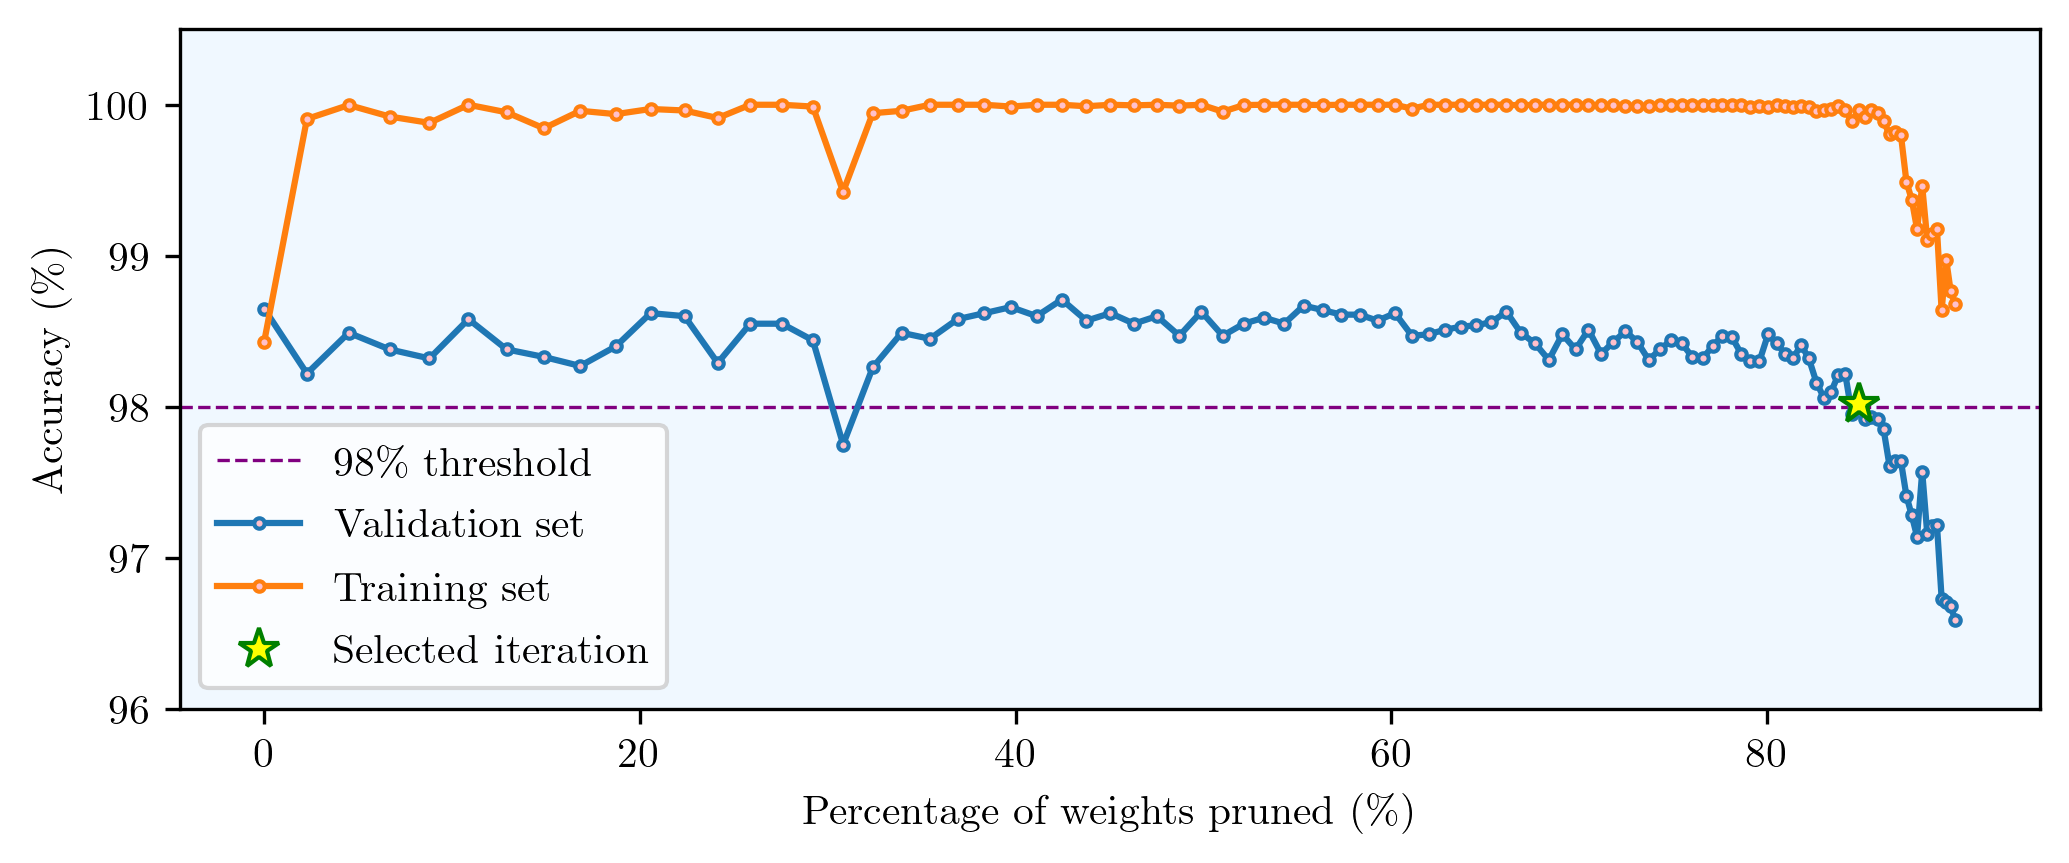

In [119]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['font.family'] = 'DejaVu Sans'


plt.figure(figsize=(8,3))
plt.axhline(y=98, color='purple', linestyle='--', linewidth=.8, label='98\% threshold')
plt.plot(np.array(rates) * 100, np.array(accs) * 100, '-o', markersize=2.5, markerfacecolor='pink', label='Validation set')
plt.plot(np.array(rates) * 100, np.array(accs_train) * 100, '-o', markersize=2.5, markerfacecolor='pink', label='Training set')
plt.plot([rates[82] * 100], [accs[82] * 100], '*', color='green', markersize=10, markerfacecolor='yellow', label='Selected iteration')
#plt.plot([rates[82] * 100], [accs_train[82] * 100], '*', color='green', markersize=10, markerfacecolor='yellow')

axes = plt.gca()
axes.set_ylim([96, 100.5])
plt.legend()
plt.xlabel('Percentage of weights pruned (\%)')
plt.ylabel('Accuracy (\%)')

axes.set_facecolor('aliceblue')

plt.savefig('plots/lottery.pdf', format='pdf', bbox_inches = "tight")

In [118]:
rates[82]

0.8486438751563794

In [16]:
model_pruned_final = tf.keras.models.load_model('saved_model/pruned84.8')
model_pruned_final.evaluate(valX, valY)
model_pruned_final.evaluate(testX, testY)

313/313 [==============================] - 1s 2ms/step - loss: 0.1175 - accuracy: 0.9789


[0.11750126630067825, 0.9789000153541565]

In [ ]:
masks = []
for layer_idx, weight_idx in pruner.prunable_tuples:
    mask = pruner.prune_masks_map[(layer_idx, weight_idx)]
    weight_mask = np.array(mask[0])
    masks.append(weight_mask)
    print(np.sum(weight_mask))

In [19]:
model_pruned_final.save('saved_model/pruned_final')

INFO:tensorflow:Assets written to: saved_model/pruned_final/assets


In [20]:
save_data(model_pruned_final, 'LOTTERY', testX, linear=[])

(3, 2)


### FAST MNIST model

#### Train model

In [46]:
name = 'MNIST-OPT'

trainX, trainY, valX, valY, testX, testY = load_mnist()
trainX, valX, testX = norm_(trainX, valX, testX)

In [ ]:
model2.fit(
    trainX, trainY,
    epochs=500,
    validation_data=(valX, valY),
    batch_size=32,
    workers=6,
)

model2.save('saved_model/' + name)

In [65]:
model2 = tf.keras.models.load_model('saved_model/' + name)

In [66]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_6 (ZeroPaddin (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 5)         50        
_________________________________________________________________
activation_15 (Activation)   (None, 28, 28, 5)         0         
_________________________________________________________________
average_pooling2d_12 (Averag (None, 14, 14, 5)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 50)        2300      
_________________________________________________________________
average_pooling2d_13 (Averag (None, 12, 12, 50)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 7200)             

In [67]:
model2.evaluate(testX, testY)

313/313 [==============================] - 1s 1ms/step - loss: 0.0455 - accuracy: 0.9898


[0.045468345284461975, 0.989799976348877]

In [68]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_6 (ZeroPaddin (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 5)         50        
_________________________________________________________________
activation_15 (Activation)   (None, 28, 28, 5)         0         
_________________________________________________________________
average_pooling2d_12 (Averag (None, 14, 14, 5)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 50)        2300      
_________________________________________________________________
average_pooling2d_13 (Averag (None, 12, 12, 50)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 7200)             

#### Combine linear layers

In [69]:
W_conv = model2.layers[4].weights[0]
W_conv = np.transpose(W_conv, (3, 2, 0, 1))
W_conv_biases = model2.layers[4].weights[1]

M_1 = conv_weights(d_in=28, W_c=avg_pool_weights(c_in=5, k=3), s=2, padding='same', pool=True)
M_2 = conv_weights(d_in=14, W_c=W_conv, s=1, padding='valid')
M_3 = conv_weights(d_in=12, W_c=avg_pool_weights(c_in=50, k=3), s=1, padding='same', pool=True)
M_4 = dense_weights(model2.layers[7].weights[0].numpy(), 50).transpose()

b_2 = conv_biases(d_in=14, W_c=W_conv, biases=W_conv_biases, s=1, padding='valid')
b_4 = model2.layers[7].weights[1].numpy()

100%|██████████| 7200/7200 [00:02<00:00, 2552.76it/s]


In [70]:
M = M_4 @ M_3 @ M_2 @ M_1

In [71]:
M.shape

(32, 3920)

In [72]:
b = M_4 @ M_3 @ b_2 + b_4

In [73]:
def compare(a, b):
    plt.figure(figsize=(15, 3))
    plt.plot(a, label='true')
    plt.plot(b + .5, label='approx')
    plt.legend()
    plt.show()

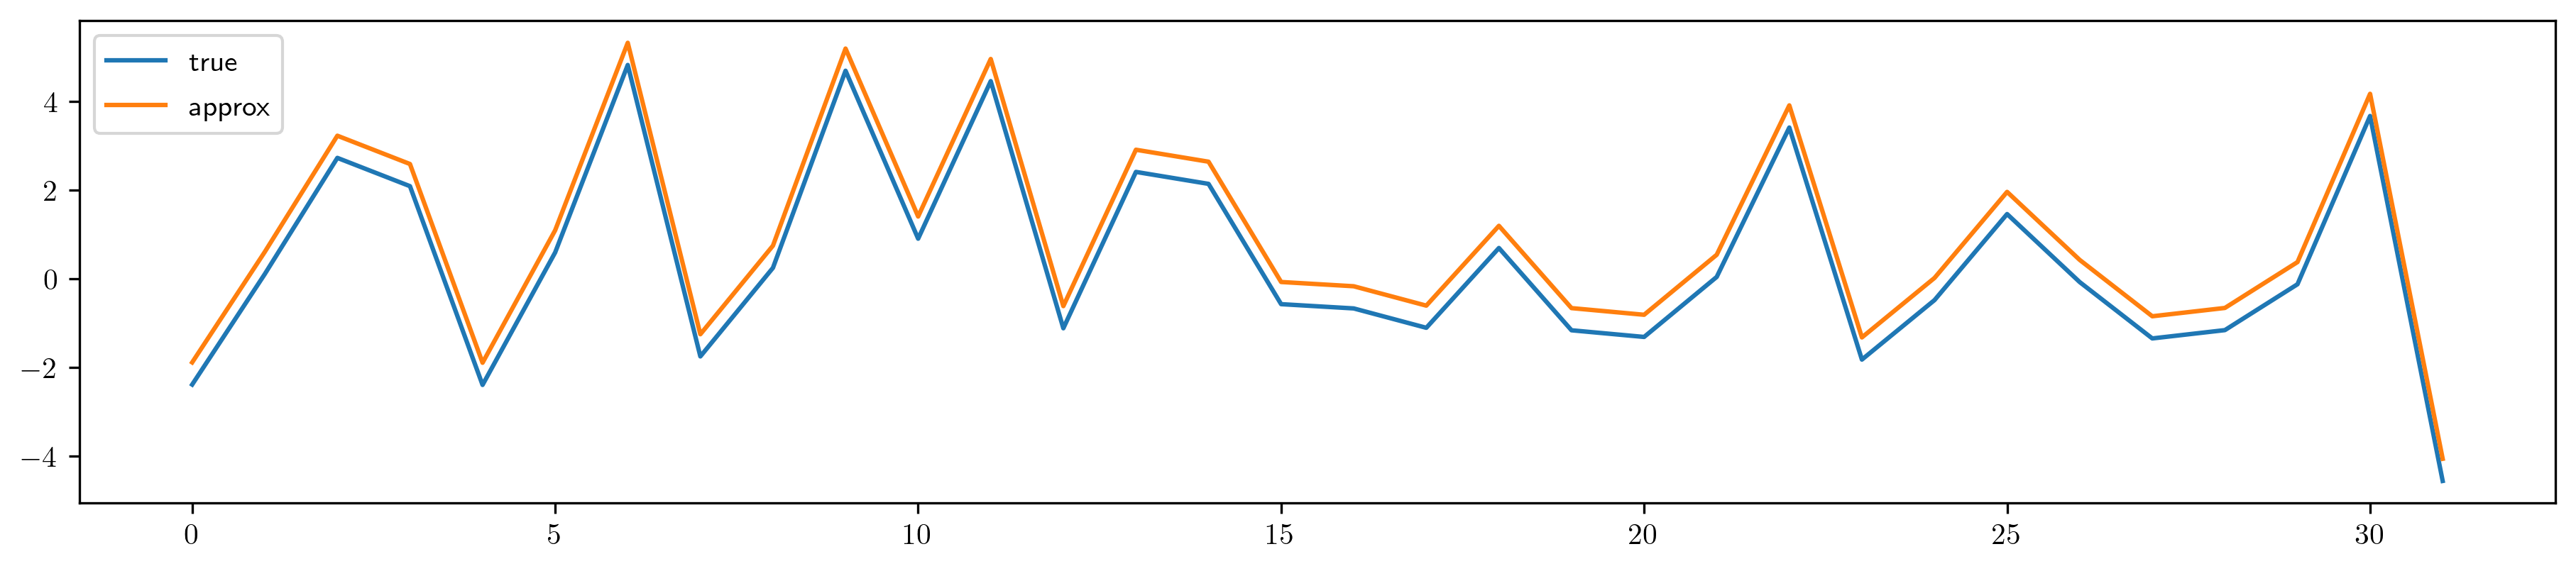

In [74]:
image = np.random.uniform(-1, 1, (1, 28, 28, 5))

ref = model2.layers[7](model2.layers[6](model2.layers[5](model2.layers[4](model2.layers[3](image))))).numpy()[0]
test = np.matmul(M, np.transpose(image, (0, 3, 1, 2)).flatten()) + b


compare(ref, test)

In [75]:
save_data(model2, name, testX, linear=[(M.transpose(), b, 3, 8)])

#### Exploding gradients

In [10]:
def square_activation(x):
    return K.square(x)

def special_activation(x):
    return 0.125 * K.square(x) + 0.5 * x + 0.125

In [11]:
for i in range(4):
    mnist_opt_bn().save_weights('saved_weights/MNIST-OPT-INIT' + str(i))

In [12]:
activations = [square_activation, special_activation, 'relu']
hs = []

for i in range(4):
    d = []
        
    for a in activations:
        cn = mnist_opt_bn(a)
        cn.load_weights('saved_weights/MNIST-OPT-INIT' + str(i))
        cn.layers[3] = a
        cn.layers[10] = a
    
        callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)
        history = cn.fit(
            trainX, trainY,
            epochs=80,
            validation_data=(testX, testY),
            batch_size=128,
            workers=6
        )
        d.append(history.history)
    hs.append(d)

Epoch 1/80
469/469 [==============================] - 5s 3ms/step - loss: 1.6481 - accuracy: 0.5081 - val_loss: 3.0294 - val_accuracy: 0.2191
Epoch 2/80
469/469 [==============================] - 1s 3ms/step - loss: 0.4184 - accuracy: 0.9128 - val_loss: 0.2951 - val_accuracy: 0.9406
Epoch 3/80
469/469 [==============================] - 1s 3ms/step - loss: 0.2932 - accuracy: 0.9432 - val_loss: 0.2312 - val_accuracy: 0.9549
Epoch 4/80
469/469 [==============================] - 1s 3ms/step - loss: 0.2278 - accuracy: 0.9576 - val_loss: 0.1766 - val_accuracy: 0.9661
Epoch 5/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1911 - accuracy: 0.9634 - val_loss: 0.1528 - val_accuracy: 0.9692
Epoch 6/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1612 - accuracy: 0.9694 - val_loss: 0.1332 - val_accuracy: 0.9740
Epoch 7/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1431 - accuracy: 0.9734 - val_loss: 0.1212 - val_accuracy: 0.9730
Epoch 

469/469 [==============================] - 1s 3ms/step - loss: 0.0498 - accuracy: 0.9875 - val_loss: 0.0533 - val_accuracy: 0.9851
Epoch 36/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0481 - accuracy: 0.9881 - val_loss: 0.0548 - val_accuracy: 0.9850
Epoch 37/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0467 - accuracy: 0.9884 - val_loss: 0.0530 - val_accuracy: 0.9848
Epoch 38/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0433 - accuracy: 0.9893 - val_loss: 0.0518 - val_accuracy: 0.9838
Epoch 39/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0442 - accuracy: 0.9892 - val_loss: 0.0527 - val_accuracy: 0.9843
Epoch 40/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0417 - accuracy: 0.9901 - val_loss: 0.0521 - val_accuracy: 0.9854
Epoch 41/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0422 - accuracy: 0.9896 - val_loss: 0.0474 - val_accuracy: 0.9864
Epoch 42/80

469/469 [==============================] - 1s 3ms/step - loss: 0.0227 - accuracy: 0.9947 - val_loss: 0.0527 - val_accuracy: 0.9836
Epoch 70/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0230 - accuracy: 0.9945 - val_loss: 0.0463 - val_accuracy: 0.9855
Epoch 71/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0222 - accuracy: 0.9948 - val_loss: 0.0486 - val_accuracy: 0.9851
Epoch 72/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0232 - accuracy: 0.9945 - val_loss: 0.0487 - val_accuracy: 0.9844
Epoch 73/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0227 - accuracy: 0.9949 - val_loss: 0.0495 - val_accuracy: 0.9840
Epoch 74/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0222 - accuracy: 0.9953 - val_loss: 0.0494 - val_accuracy: 0.9845
Epoch 75/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0225 - accuracy: 0.9947 - val_loss: 0.0429 - val_accuracy: 0.9863
Epoch 76/80

469/469 [==============================] - 1s 3ms/step - loss: 0.0704 - accuracy: 0.9835 - val_loss: 0.0643 - val_accuracy: 0.9839
Epoch 24/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0664 - accuracy: 0.9847 - val_loss: 0.0648 - val_accuracy: 0.9826
Epoch 25/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0631 - accuracy: 0.9846 - val_loss: 0.0609 - val_accuracy: 0.9843
Epoch 26/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0631 - accuracy: 0.9852 - val_loss: 0.0619 - val_accuracy: 0.9824
Epoch 27/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0580 - accuracy: 0.9861 - val_loss: 0.0587 - val_accuracy: 0.9834
Epoch 28/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0565 - accuracy: 0.9864 - val_loss: 0.0592 - val_accuracy: 0.9842
Epoch 29/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0579 - accuracy: 0.9858 - val_loss: 0.0550 - val_accuracy: 0.9834
Epoch 30/80

469/469 [==============================] - 1s 3ms/step - loss: 0.0315 - accuracy: 0.9923 - val_loss: 0.0474 - val_accuracy: 0.9859
Epoch 58/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0296 - accuracy: 0.9932 - val_loss: 0.0422 - val_accuracy: 0.9874
Epoch 59/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0284 - accuracy: 0.9931 - val_loss: 0.0429 - val_accuracy: 0.9875
Epoch 60/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0270 - accuracy: 0.9938 - val_loss: 0.0436 - val_accuracy: 0.9868
Epoch 61/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0289 - accuracy: 0.9930 - val_loss: 0.0422 - val_accuracy: 0.9865
Epoch 62/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0269 - accuracy: 0.9933 - val_loss: 0.0447 - val_accuracy: 0.9857
Epoch 63/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0271 - accuracy: 0.9935 - val_loss: 0.0430 - val_accuracy: 0.9871
Epoch 64/80

469/469 [==============================] - 1s 3ms/step - loss: 0.1508 - accuracy: 0.9756 - val_loss: 0.1303 - val_accuracy: 0.9769
Epoch 12/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1417 - accuracy: 0.9747 - val_loss: 0.1204 - val_accuracy: 0.9785
Epoch 13/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1260 - accuracy: 0.9778 - val_loss: 0.1264 - val_accuracy: 0.9747
Epoch 14/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1202 - accuracy: 0.9771 - val_loss: 0.1048 - val_accuracy: 0.9801
Epoch 15/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1111 - accuracy: 0.9783 - val_loss: 0.0986 - val_accuracy: 0.9794
Epoch 16/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1044 - accuracy: 0.9790 - val_loss: 0.0926 - val_accuracy: 0.9799
Epoch 17/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0989 - accuracy: 0.9791 - val_loss: 0.0927 - val_accuracy: 0.9814
Epoch 18/80

469/469 [==============================] - 1s 3ms/step - loss: 0.0372 - accuracy: 0.9905 - val_loss: 0.0518 - val_accuracy: 0.9839
Epoch 46/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0361 - accuracy: 0.9906 - val_loss: 0.0507 - val_accuracy: 0.9837
Epoch 47/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0335 - accuracy: 0.9919 - val_loss: 0.0762 - val_accuracy: 0.9754
Epoch 48/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0331 - accuracy: 0.9919 - val_loss: 0.0641 - val_accuracy: 0.9801
Epoch 49/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0342 - accuracy: 0.9914 - val_loss: 0.0528 - val_accuracy: 0.9846
Epoch 50/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0331 - accuracy: 0.9916 - val_loss: 0.0516 - val_accuracy: 0.9840
Epoch 51/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0323 - accuracy: 0.9918 - val_loss: 0.0596 - val_accuracy: 0.9822
Epoch 52/80

469/469 [==============================] - 1s 3ms/step - loss: 0.0100 - accuracy: 0.9980 - val_loss: 0.0579 - val_accuracy: 0.9861
Epoch 80/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0108 - accuracy: 0.9976 - val_loss: 0.0614 - val_accuracy: 0.9855
Epoch 1/80
469/469 [==============================] - 2s 3ms/step - loss: 1.1039 - accuracy: 0.7430 - val_loss: 1.0514 - val_accuracy: 0.7936
Epoch 2/80
469/469 [==============================] - 1s 3ms/step - loss: 0.5733 - accuracy: 0.9257 - val_loss: 0.4604 - val_accuracy: 0.9314
Epoch 3/80
469/469 [==============================] - 1s 3ms/step - loss: 0.4511 - accuracy: 0.9489 - val_loss: 0.3619 - val_accuracy: 0.9564
Epoch 4/80
469/469 [==============================] - 1s 3ms/step - loss: 0.3720 - accuracy: 0.9570 - val_loss: 0.3095 - val_accuracy: 0.9642
Epoch 5/80
469/469 [==============================] - 1s 3ms/step - loss: 0.3128 - accuracy: 0.9627 - val_loss: 0.2604 - val_accuracy: 0.9666
Epoch 6/80
469/4

469/469 [==============================] - 1s 3ms/step - loss: 0.0482 - accuracy: 0.9872 - val_loss: 0.0554 - val_accuracy: 0.9834
Epoch 34/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0491 - accuracy: 0.9876 - val_loss: 0.0560 - val_accuracy: 0.9836
Epoch 35/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0459 - accuracy: 0.9884 - val_loss: 0.0560 - val_accuracy: 0.9844
Epoch 36/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0431 - accuracy: 0.9892 - val_loss: 0.0584 - val_accuracy: 0.9834
Epoch 37/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0427 - accuracy: 0.9897 - val_loss: 0.0564 - val_accuracy: 0.9836
Epoch 38/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0419 - accuracy: 0.9896 - val_loss: 0.0647 - val_accuracy: 0.9805
Epoch 39/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0423 - accuracy: 0.9887 - val_loss: 0.0649 - val_accuracy: 0.9796
Epoch 40/80

In [13]:
for i in range(4):
    mnist_opt().save_weights('saved_weights/MNIST-OPT-INIT' + str(i))
    
for i in range(4):
    d = []
        
    for a in activations:
        cn = mnist_opt(a)
        cn.load_weights('saved_weights/MNIST-OPT-INIT' + str(i))

        cn.layers[2] = a
        cn.layers[8] = a
    
        callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)
        history = cn.fit(
            trainX, trainY,
            epochs=80,
            validation_data=(testX, testY),
            batch_size=128,
            workers=6
        )
        d.append(history.history)
    hs.append(d)

Epoch 1/80
469/469 [==============================] - 1s 3ms/step - loss: 1.6865 - accuracy: 0.4887 - val_loss: 0.5073 - val_accuracy: 0.8675
Epoch 2/80
469/469 [==============================] - 1s 2ms/step - loss: 0.5020 - accuracy: 0.8668 - val_loss: 0.4122 - val_accuracy: 0.8877
Epoch 3/80
469/469 [==============================] - 1s 2ms/step - loss: 0.4180 - accuracy: 0.8856 - val_loss: 0.3557 - val_accuracy: 0.9045
Epoch 4/80
469/469 [==============================] - 1s 2ms/step - loss: 0.3608 - accuracy: 0.9014 - val_loss: 0.3144 - val_accuracy: 0.9152
Epoch 5/80
469/469 [==============================] - 1s 2ms/step - loss: 0.3115 - accuracy: 0.9152 - val_loss: 0.2679 - val_accuracy: 0.9259
Epoch 6/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2713 - accuracy: 0.9260 - val_loss: 0.2353 - val_accuracy: 0.9385
Epoch 7/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2356 - accuracy: 0.9346 - val_loss: 0.2109 - val_accuracy: 0.9451
Epoch 

469/469 [==============================] - 1s 2ms/step - loss: 0.1839 - accuracy: 0.9458 - val_loss: 0.1809 - val_accuracy: 0.9458
Epoch 36/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1843 - accuracy: 0.9451 - val_loss: 0.1783 - val_accuracy: 0.9471
Epoch 37/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1795 - accuracy: 0.9469 - val_loss: 0.1712 - val_accuracy: 0.9491
Epoch 38/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1753 - accuracy: 0.9474 - val_loss: 0.1687 - val_accuracy: 0.9497
Epoch 39/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1674 - accuracy: 0.9492 - val_loss: 0.1667 - val_accuracy: 0.9482
Epoch 40/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1685 - accuracy: 0.9493 - val_loss: 0.1639 - val_accuracy: 0.9514
Epoch 41/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1629 - accuracy: 0.9525 - val_loss: 0.1628 - val_accuracy: 0.9527
Epoch 42/80

469/469 [==============================] - 1s 2ms/step - loss: 0.1009 - accuracy: 0.9699 - val_loss: 0.0991 - val_accuracy: 0.9695
Epoch 70/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0994 - accuracy: 0.9710 - val_loss: 0.1004 - val_accuracy: 0.9699
Epoch 71/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0967 - accuracy: 0.9717 - val_loss: 0.0979 - val_accuracy: 0.9703
Epoch 72/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0948 - accuracy: 0.9712 - val_loss: 0.1031 - val_accuracy: 0.9684
Epoch 73/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0986 - accuracy: 0.9705 - val_loss: 0.0965 - val_accuracy: 0.9714
Epoch 74/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0928 - accuracy: 0.9719 - val_loss: 0.0957 - val_accuracy: 0.9719
Epoch 75/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0964 - accuracy: 0.9707 - val_loss: 0.0953 - val_accuracy: 0.9713
Epoch 76/80

469/469 [==============================] - 1s 2ms/step - loss: 0.2011 - accuracy: 0.9390 - val_loss: 0.1903 - val_accuracy: 0.9444
Epoch 24/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1955 - accuracy: 0.9409 - val_loss: 0.1868 - val_accuracy: 0.9439
Epoch 25/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1904 - accuracy: 0.9429 - val_loss: 0.1853 - val_accuracy: 0.9442
Epoch 26/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1845 - accuracy: 0.9457 - val_loss: 0.1770 - val_accuracy: 0.9468
Epoch 27/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1778 - accuracy: 0.9460 - val_loss: 0.1773 - val_accuracy: 0.9484
Epoch 28/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1726 - accuracy: 0.9475 - val_loss: 0.1684 - val_accuracy: 0.9500
Epoch 29/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1746 - accuracy: 0.9472 - val_loss: 0.1669 - val_accuracy: 0.9520
Epoch 30/80

469/469 [==============================] - 1s 2ms/step - loss: 0.0862 - accuracy: 0.9737 - val_loss: 0.0835 - val_accuracy: 0.9733
Epoch 58/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0868 - accuracy: 0.9741 - val_loss: 0.0826 - val_accuracy: 0.9741
Epoch 59/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0841 - accuracy: 0.9748 - val_loss: 0.0850 - val_accuracy: 0.9737
Epoch 60/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0826 - accuracy: 0.9757 - val_loss: 0.0817 - val_accuracy: 0.9739
Epoch 61/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0866 - accuracy: 0.9736 - val_loss: 0.0803 - val_accuracy: 0.9744
Epoch 62/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0837 - accuracy: 0.9751 - val_loss: 0.0810 - val_accuracy: 0.9746
Epoch 63/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0806 - accuracy: 0.9761 - val_loss: 0.0797 - val_accuracy: 0.9753
Epoch 64/80

469/469 [==============================] - 1s 2ms/step - loss: 0.2832 - accuracy: 0.9135 - val_loss: 0.2634 - val_accuracy: 0.9219
Epoch 12/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2763 - accuracy: 0.9154 - val_loss: 0.2506 - val_accuracy: 0.9248
Epoch 13/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2587 - accuracy: 0.9211 - val_loss: 0.2427 - val_accuracy: 0.9271
Epoch 14/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2604 - accuracy: 0.9212 - val_loss: 0.2304 - val_accuracy: 0.9324
Epoch 15/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2481 - accuracy: 0.9258 - val_loss: 0.2231 - val_accuracy: 0.9326
Epoch 16/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2402 - accuracy: 0.9281 - val_loss: 0.2198 - val_accuracy: 0.9339
Epoch 17/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2288 - accuracy: 0.9317 - val_loss: 0.2140 - val_accuracy: 0.9373
Epoch 18/80

469/469 [==============================] - 1s 2ms/step - loss: 0.0949 - accuracy: 0.9708 - val_loss: 0.0872 - val_accuracy: 0.9727
Epoch 46/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0918 - accuracy: 0.9731 - val_loss: 0.0841 - val_accuracy: 0.9736
Epoch 47/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0903 - accuracy: 0.9733 - val_loss: 0.0844 - val_accuracy: 0.9731
Epoch 48/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0924 - accuracy: 0.9725 - val_loss: 0.0821 - val_accuracy: 0.9743
Epoch 49/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0941 - accuracy: 0.9717 - val_loss: 0.0817 - val_accuracy: 0.9744
Epoch 50/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0886 - accuracy: 0.9733 - val_loss: 0.0818 - val_accuracy: 0.9748
Epoch 51/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0877 - accuracy: 0.9729 - val_loss: 0.0796 - val_accuracy: 0.9743
Epoch 52/80

469/469 [==============================] - 1s 2ms/step - loss: 0.0475 - accuracy: 0.9856 - val_loss: 0.0465 - val_accuracy: 0.9848
Epoch 80/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0474 - accuracy: 0.9856 - val_loss: 0.0493 - val_accuracy: 0.9831
Epoch 1/80
469/469 [==============================] - 1s 3ms/step - loss: 1.9942 - accuracy: 0.4624 - val_loss: 0.6613 - val_accuracy: 0.8170
Epoch 2/80
469/469 [==============================] - 1s 2ms/step - loss: 0.6040 - accuracy: 0.8296 - val_loss: 0.4674 - val_accuracy: 0.8677
Epoch 3/80
469/469 [==============================] - 1s 2ms/step - loss: 0.4783 - accuracy: 0.8592 - val_loss: 0.4337 - val_accuracy: 0.8773
Epoch 4/80
469/469 [==============================] - 1s 2ms/step - loss: 0.4348 - accuracy: 0.8742 - val_loss: 0.3938 - val_accuracy: 0.8866
Epoch 5/80
469/469 [==============================] - 1s 2ms/step - loss: 0.4113 - accuracy: 0.8819 - val_loss: 0.3855 - val_accuracy: 0.8887
Epoch 6/80
469/4

469/469 [==============================] - 1s 2ms/step - loss: 0.1069 - accuracy: 0.9696 - val_loss: 0.0960 - val_accuracy: 0.9684
Epoch 34/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1065 - accuracy: 0.9694 - val_loss: 0.0943 - val_accuracy: 0.9701
Epoch 35/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1025 - accuracy: 0.9703 - val_loss: 0.0902 - val_accuracy: 0.9707
Epoch 36/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1031 - accuracy: 0.9692 - val_loss: 0.0922 - val_accuracy: 0.9701
Epoch 37/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1038 - accuracy: 0.9701 - val_loss: 0.0872 - val_accuracy: 0.9732
Epoch 38/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0999 - accuracy: 0.9717 - val_loss: 0.0885 - val_accuracy: 0.9706
Epoch 39/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0999 - accuracy: 0.9713 - val_loss: 0.0850 - val_accuracy: 0.9721
Epoch 40/80

In [9]:
hs = np.load('histories.npy', allow_pickle=True)

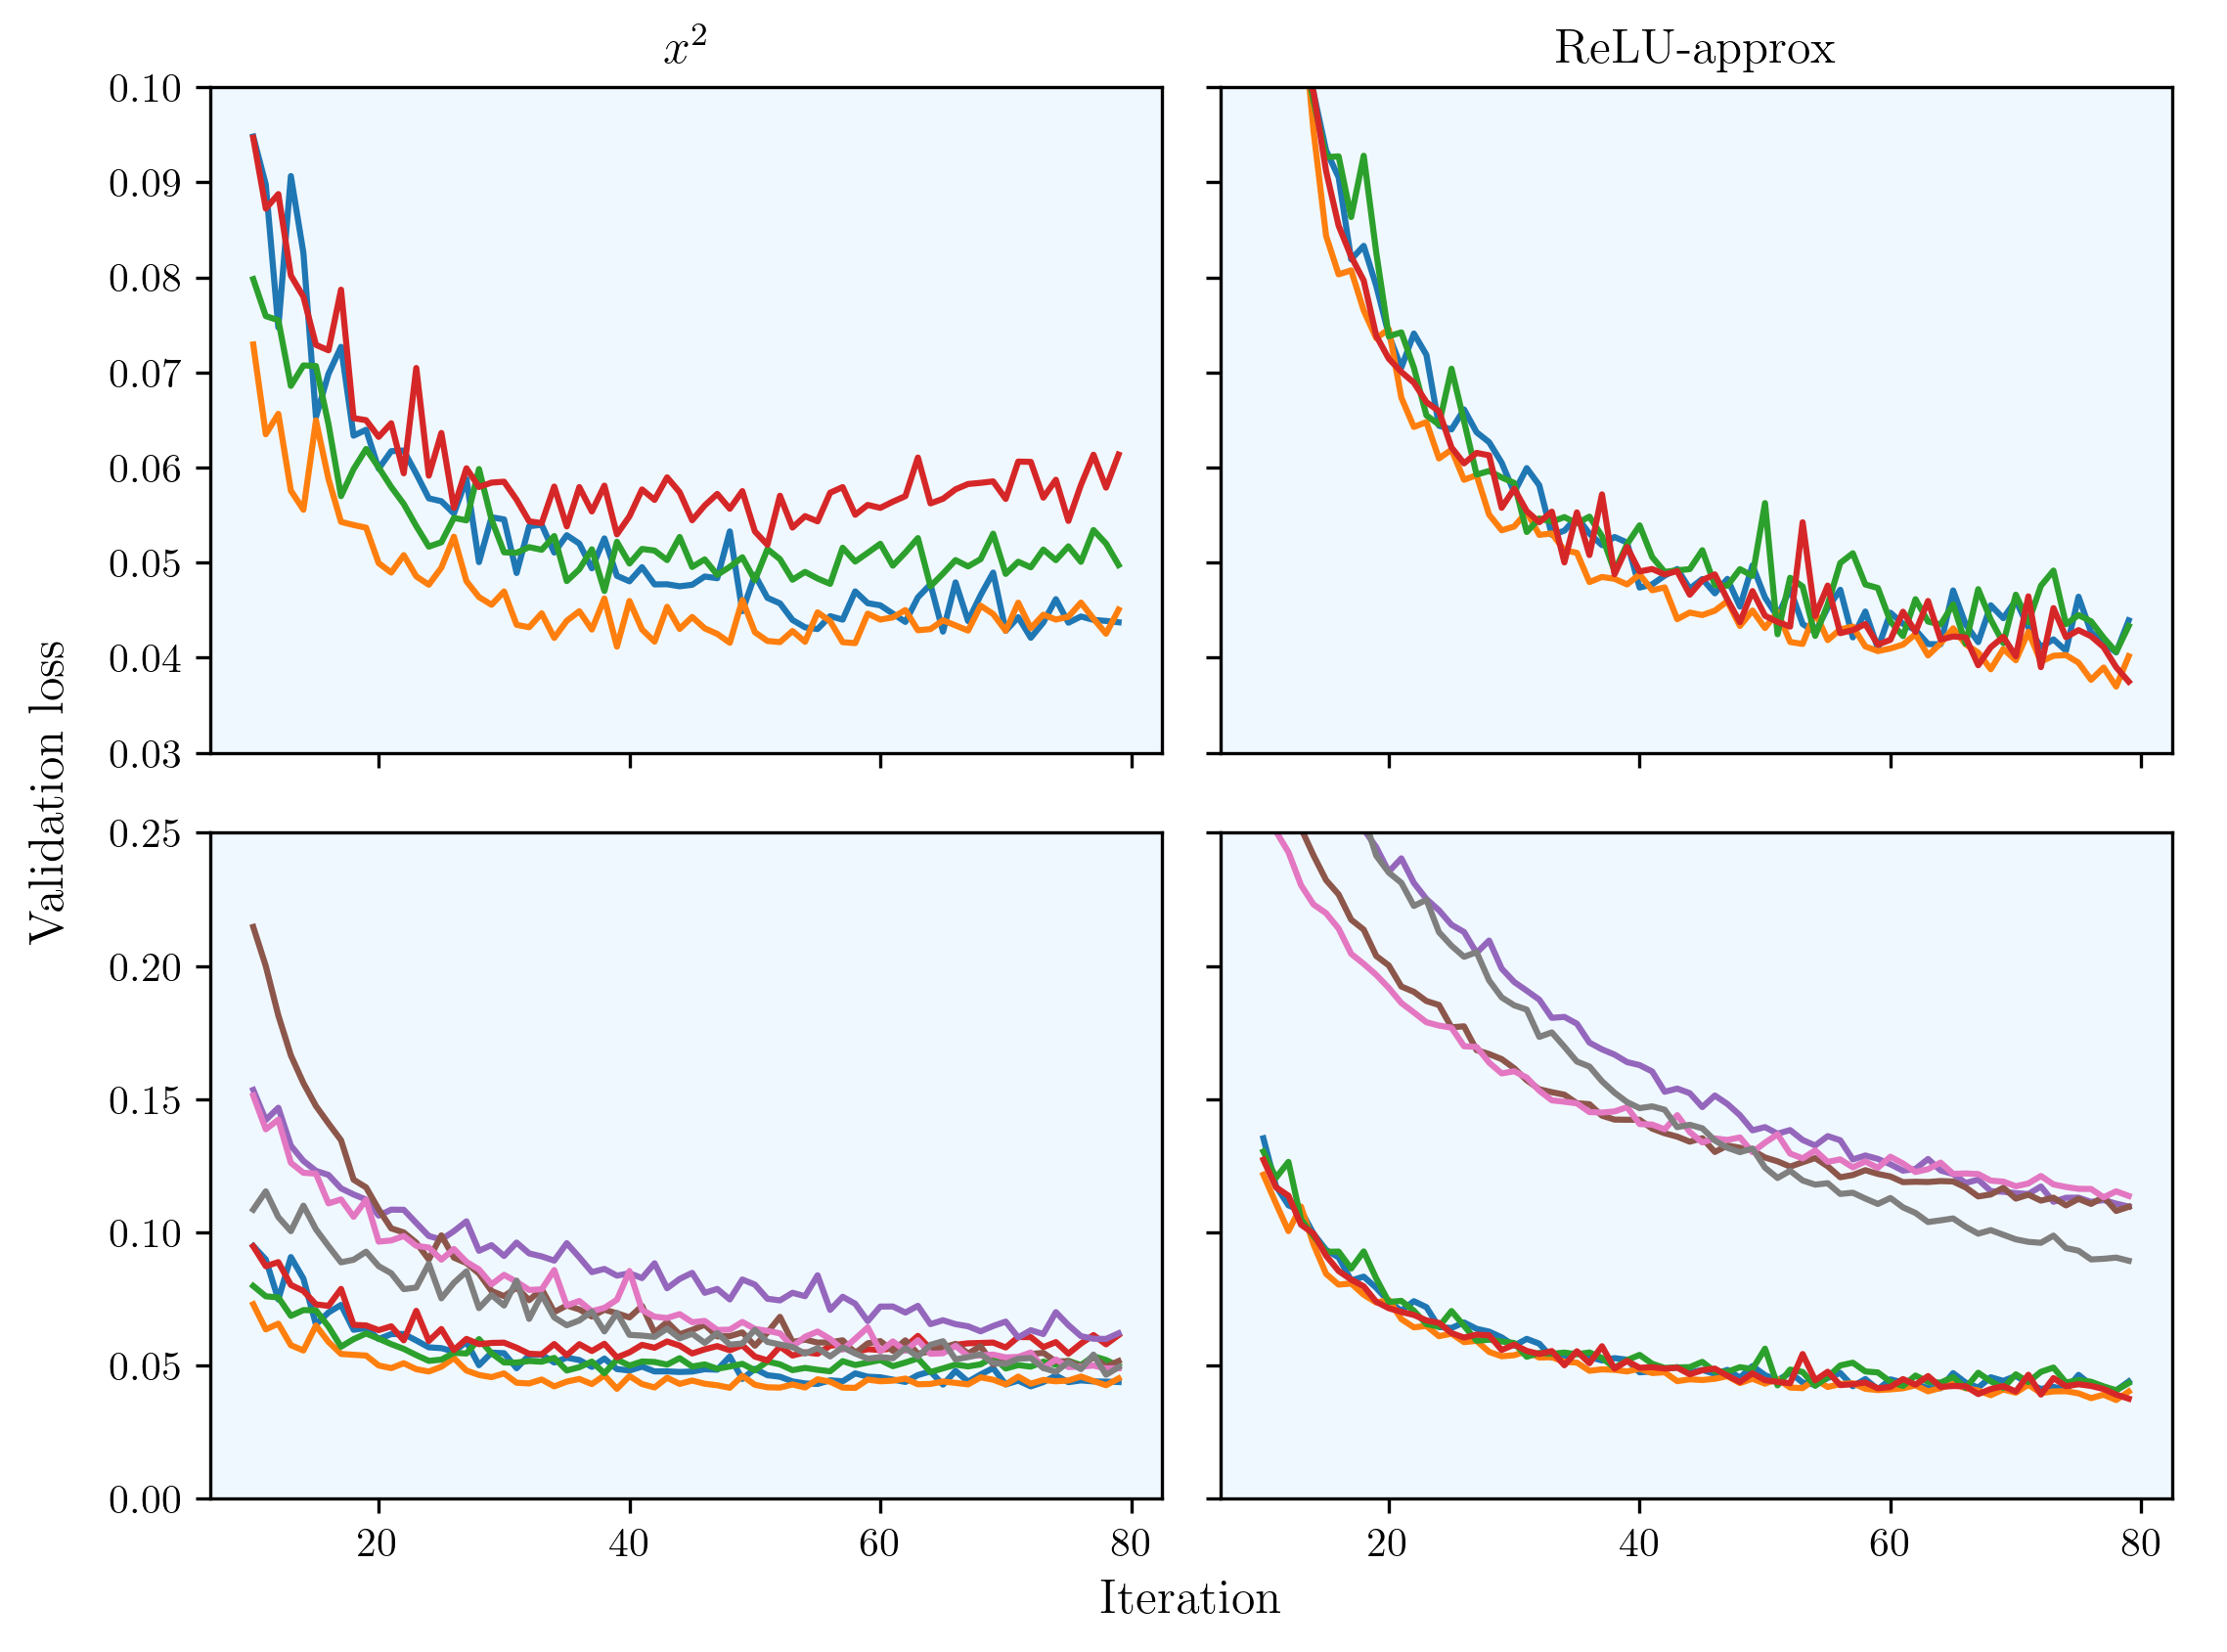

In [70]:
import numpy as np
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 's'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(2,2, figsize=(8,6), sharex=True, sharey='row')


for i in range(0,4):
    axs[0, 0].plot(np.arange(10, 80), hs[i][0]['val_loss'][10:])
axs[0, 0].set_ylim([0.03,0.1])

for i in range(0,4):
    axs[0, 1].plot(np.arange(10, 80), hs[i][1]['val_loss'][10:])
axs[0, 1].set_ylim([0.03,0.1])


for i in range(0,4):
    axs[1, 0].plot(np.arange(10, 80), hs[i][0]['val_loss'][10:])
for i in range(0,4):
    axs[1, 1].plot(np.arange(10, 80), hs[i][1]['val_loss'][10:])
    
for i in range(4,8):
    axs[1, 0].plot(np.arange(10, 80), hs[i][0]['val_loss'][10:])
for i in range(4,8):
    axs[1, 1].plot(np.arange(10, 80), hs[i][1]['val_loss'][10:])
axs[1, 1].set_ylim([0.0,0.25])
axs[1, 0].set_ylim([0.0,0.25])

axs[0, 0].title.set_text('$x^2$')
axs[0, 1].title.set_text('ReLU-approx')


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Validation loss', fontsize=12)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.07, 0.5)
plt.tight_layout()

axs[0, 0].set_facecolor('aliceblue')
axs[0, 1].set_facecolor('aliceblue')
axs[1, 0].set_facecolor('aliceblue')
axs[1, 1].set_facecolor('aliceblue')

fig.savefig('plots/act.pdf', format='pdf', bbox_inches = "tight")

### CIFAR

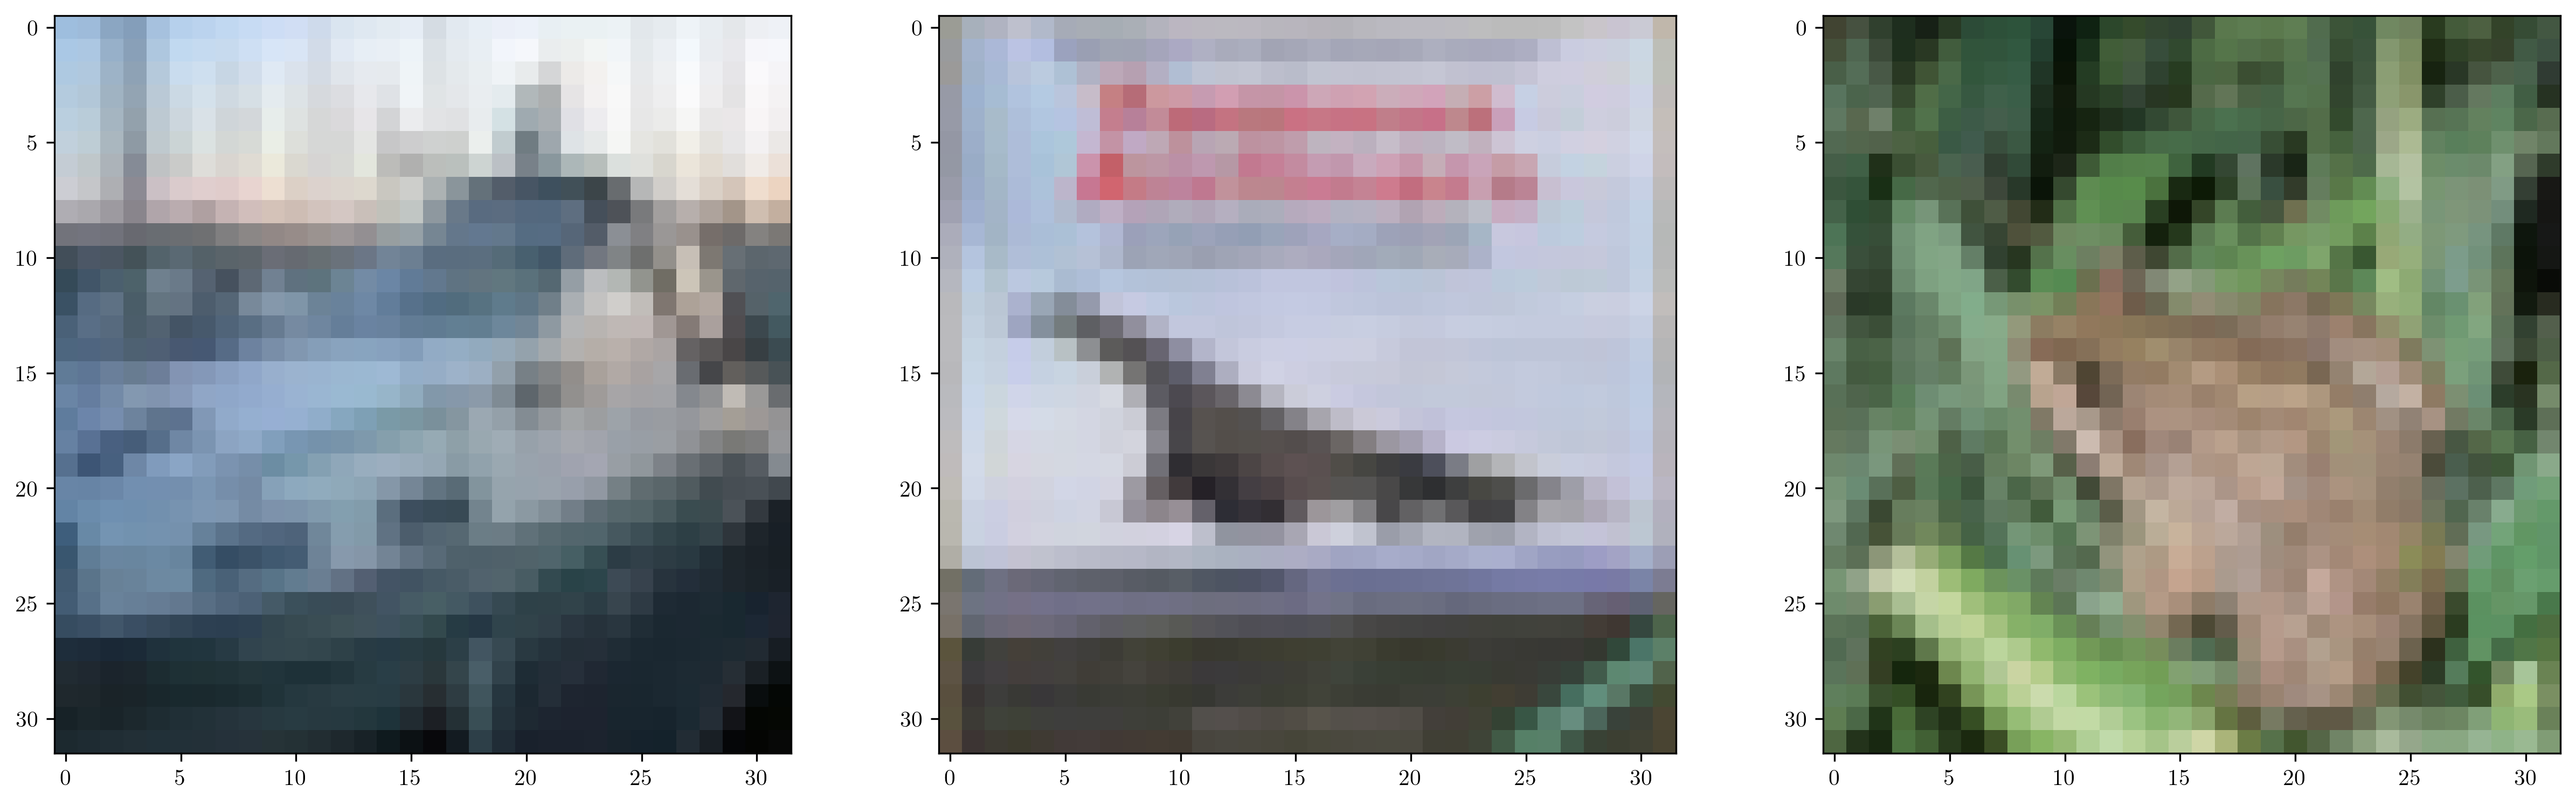

In [7]:
trainX, trainY, testX, testY = load_cifar10()
trainX = norm(trainX)
testX = norm(testX)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(testX[2])
ax[1].imshow(testX[3])
ax[2].imshow(testX[4])

In [ ]:
model3 = cifar()

model3.fit(
    trainX, trainY,
    epochs=300,
    validation_data=(testX, testY),
    workers=6,
    batch_size=64,
)

model3.summary()

In [133]:
model3.save('saved_model/CIFAR-10')

INFO:tensorflow:Assets written to: saved_model/CIFAR-10/assets


In [134]:
model3 = tf.keras.models.load_model('saved_model/CIFAR-10')

In [135]:
model3.evaluate(testX, testY)

313/313 [==============================] - 0s 1ms/step - loss: 0.8765 - accuracy: 0.7153


[0.8764963150024414, 0.7153000235557556]

In [136]:
model3.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 30, 30, 18)        504       
_________________________________________________________________
activation_33 (Activation)   (None, 30, 30, 18)        0         
_________________________________________________________________
average_pooling2d_22 (Averag (None, 10, 10, 18)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 8, 8, 64)          10432     
_________________________________________________________________
dropout_22 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
activation_34 (Activation)   (None, 8, 8, 64)          0         
_________________________________________________________________
average_pooling2d_23 (Averag (None, 4, 4, 64)        

#### Combine linear layers

In [137]:
W_conv = np.transpose(model3.layers[3].weights[0], (3, 2, 0, 1))
W_conv_biases = model3.layers[3].weights[1]

M_1 = conv_weights(d_in=30, W_c=avg_pool_weights(c_in=18, k=3), s=3, padding='same', pool=True)
M_2 = conv_weights(d_in=10, W_c=W_conv, s=1, padding='valid')

b_2 = conv_biases(d_in=10, W_c=W_conv, biases=W_conv_biases, s=1, padding='valid')

100%|██████████| 4096/4096 [00:01<00:00, 3356.19it/s]


In [138]:
M_a = M_2 @ M_1
b_a = b_2

In [139]:
M_a.shape

(4096, 16200)

In [140]:
W_conv = np.transpose(model3.layers[7].weights[0], (3, 2, 0, 1))
W_conv_biases = model3.layers[7].weights[1]

M_3 = conv_weights(d_in=8, W_c=avg_pool_weights(c_in=64, k=2), s=2, padding='same', pool=True)
M_4 = conv_weights(d_in=4, W_c=W_conv, s=1, padding='valid')
M_5 = dense_weights(model3.layers[9].weights[0].numpy(), 256).transpose()

b_4 = conv_biases(d_in=4, W_c=W_conv, biases=W_conv_biases, s=1, padding='valid')
b_5 = model3.layers[9].weights[1].numpy()

100%|██████████| 1024/1024 [00:01<00:00, 937.92it/s]


In [141]:
M_b = M_5 @ M_4 @ M_3
b_b = M_5 @ b_4 + b_5

In [142]:
M_b.shape

(256, 4096)

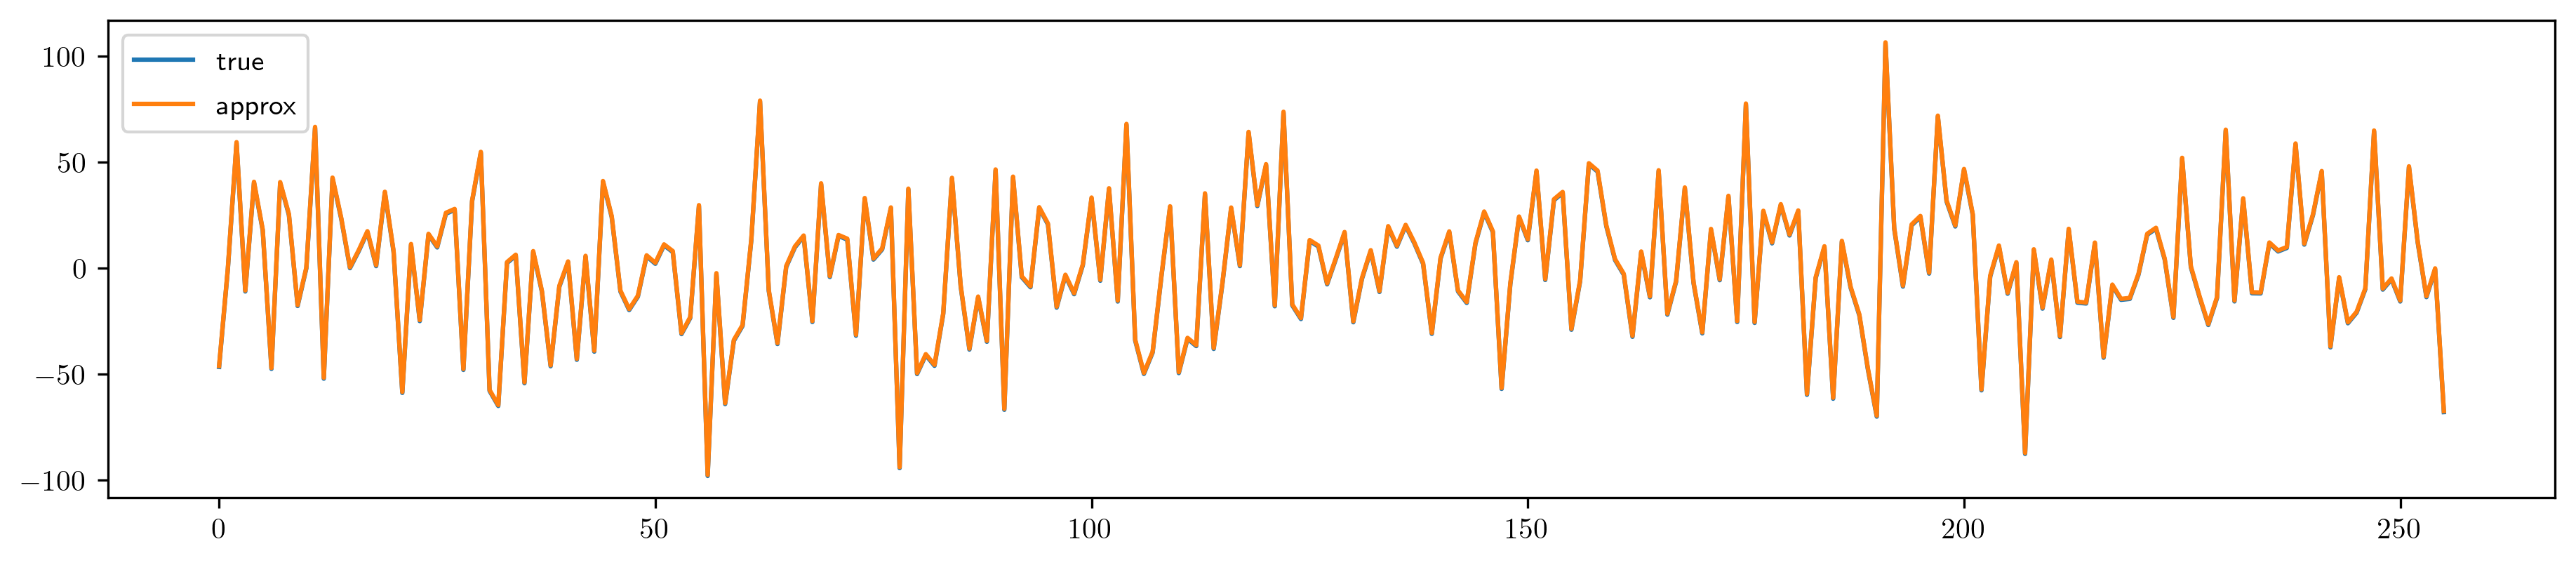

In [144]:
image = np.random.uniform(-1, 1, (1, 30, 30, 18))

ref = model3.layers[9](model3.layers[8](model3.layers[7](
    model3.layers[6](model3.layers[5](model3.layers[4](model3.layers[3](model3.layers[2](image)))))))
).numpy()[0]
test = M_a @ np.transpose(image, (0, 3, 1, 2)).flatten() + b_a
test = test ** 2
test = M_b @ test + b_b


plt.figure(figsize=(15, 3))
plt.plot(ref, label='true')
plt.plot(test + .45, label='approx')
plt.legend()
plt.show()

In [145]:
save_data(model3, 'CIFAR-BASE', testX, linear=[(M_a.transpose(), b_a, 2, 5), (M_b.transpose(), b_b, 6, 10)])

(4, 2)


In [146]:
M_2.shape

(4096, 1800)

#### SV Decomposition

In [147]:
M_a_ = M_a.transpose()
M_a_.shape

(16200, 4096)

In [148]:
X = model3.layers[3].weights[0].numpy()
X = X.reshape(-1, X.shape[-1])
X.shape

(162, 64)

In [156]:
from sklearn.utils.extmath import randomized_svd
import random
from scipy.sparse.linalg import svds

n = 13   
M = 18
N = 64
    
U, Sigma, VT = svds(X, k=n)

Sigma_ = np.zeros(shape=(n, n))
for i in range(n):
    Sigma_[i, i] = Sigma[i]

A = U @ Sigma_
B = VT

C = A @ B

In [157]:
C.shape

(162, 64)

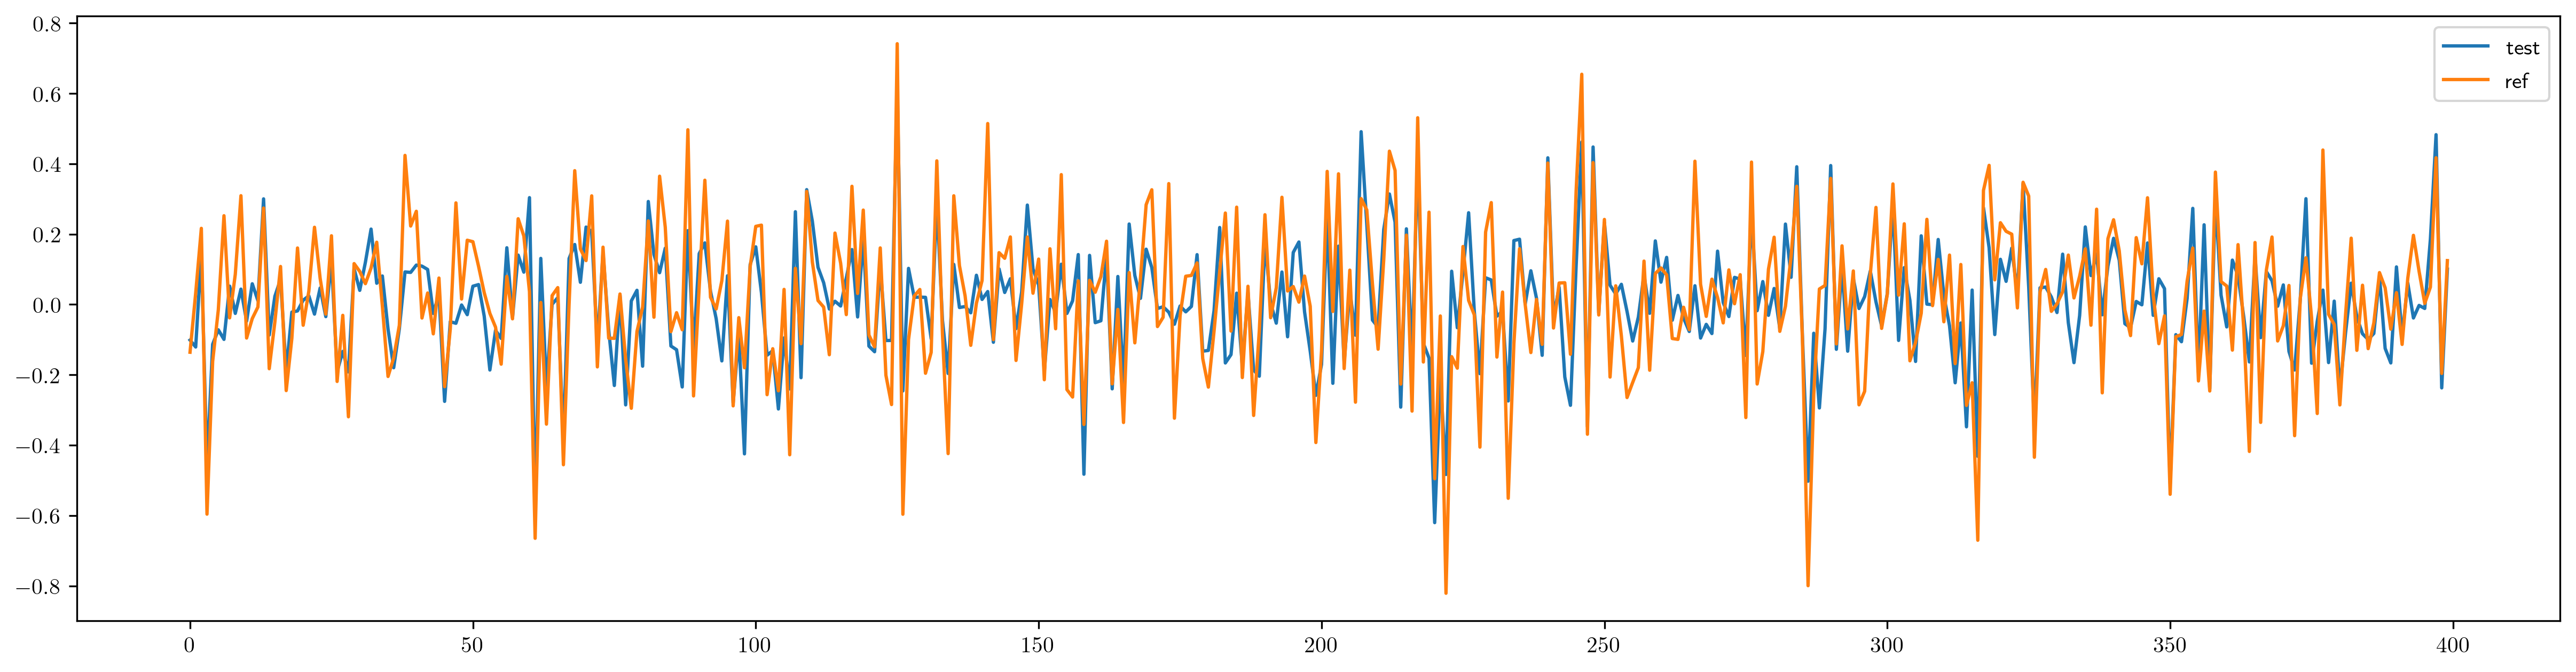

In [158]:
plt.figure(figsize=(20,5))
plt.plot(C.flatten()[:400], label='test')
plt.plot(X.flatten()[:400], label='ref')
plt.legend()
plt.show()

In [159]:
A = A.reshape(3, 3, M, n)
B = B.reshape(1, 1, n, N)

In [160]:
init1 = tf.constant_initializer(A)
init2 = tf.constant_initializer(B)

In [161]:
layers = cifar().layers
layers[3] = Conv2D(n, kernel_size=(3, 3), strides=1, kernel_initializer=init1)
layers.insert(4, Conv2D(N, kernel_size=(1, 1), strides=1, kernel_initializer=init2))
model_svd = Sequential(layers)
opt = Adam(lr=0.0005)
model_svd.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [179]:
model_svd.fit(
    trainX, trainY,
    epochs=100,
    validation_data=(testX, testY),
    workers=6,
    batch_size=64
)



Epoch 1/100
782/782 [==============================] - 3s 4ms/step - loss: 0.3208 - accuracy: 0.8949 - val_loss: 0.9485 - val_accuracy: 0.7353
Epoch 2/100
782/782 [==============================] - 3s 4ms/step - loss: 0.3274 - accuracy: 0.8916 - val_loss: 0.9788 - val_accuracy: 0.7215
Epoch 3/100
782/782 [==============================] - 3s 4ms/step - loss: 0.3239 - accuracy: 0.8915 - val_loss: 0.9424 - val_accuracy: 0.7271
Epoch 4/100
782/782 [==============================] - 3s 4ms/step - loss: 0.3203 - accuracy: 0.8927 - val_loss: 0.9591 - val_accuracy: 0.7208
Epoch 5/100
782/782 [==============================] - 3s 4ms/step - loss: 0.3322 - accuracy: 0.8902 - val_loss: 0.9577 - val_accuracy: 0.7223
Epoch 6/100
782/782 [==============================] - 3s 3ms/step - loss: 0.3242 - accuracy: 0.8929 - val_loss: 0.9847 - val_accuracy: 0.7193
Epoch 7/100
782/782 [==============================] - 3s 4ms/step - loss: 0.3260 - accuracy: 0.8938 - val_loss: 0.9989 - val_accuracy: 0.7066

Epoch 58/100
782/782 [==============================] - 3s 4ms/step - loss: 0.3265 - accuracy: 0.8933 - val_loss: 0.9606 - val_accuracy: 0.7306
Epoch 59/100
782/782 [==============================] - 3s 4ms/step - loss: 0.3192 - accuracy: 0.8952 - val_loss: 0.9683 - val_accuracy: 0.7186
Epoch 60/100
782/782 [==============================] - 3s 4ms/step - loss: 0.3290 - accuracy: 0.8925 - val_loss: 0.9513 - val_accuracy: 0.7181
Epoch 61/100
782/782 [==============================] - 3s 4ms/step - loss: 0.3147 - accuracy: 0.8951 - val_loss: 0.9976 - val_accuracy: 0.7078
Epoch 62/100
782/782 [==============================] - 3s 4ms/step - loss: 0.3386 - accuracy: 0.8888 - val_loss: 0.9795 - val_accuracy: 0.7121
Epoch 63/100
782/782 [==============================] - 3s 4ms/step - loss: 0.3221 - accuracy: 0.8924 - val_loss: 0.9822 - val_accuracy: 0.7189
Epoch 64/100
782/782 [==============================] - 3s 4ms/step - loss: 0.3282 - accuracy: 0.8925 - val_loss: 0.9768 - val_accuracy:

In [180]:
model_svd.save('saved_model/CIFAR-SVD')
model_svd.summary()
model_svd.evaluate(testX, testY)

INFO:tensorflow:Assets written to: saved_model/CIFAR-SVD/assets
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 30, 30, 18)        504       
_________________________________________________________________
activation_39 (Activation)   (None, 30, 30, 18)        0         
_________________________________________________________________
average_pooling2d_26 (Averag (None, 10, 10, 18)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 8, 8, 13)          2119      
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 8, 8, 64)          896       
_________________________________________________________________
dropout_26 (Dropout)         (None, 8, 8, 64)          0         
_______________________________________________________

[0.9599758982658386, 0.7305999994277954]

In [181]:
model_svd = tf.keras.models.load_model('saved_model/CIFAR-SVD')
model_svd.evaluate(testX, testY)

313/313 [==============================] - 1s 2ms/step - loss: 0.9600 - accuracy: 0.7306


[0.9599758982658386, 0.7305999994277954]

In [170]:
W_conv = np.transpose(model_svd.layers[3].weights[0], (3, 2, 0, 1))
W_conv_biases = model_svd.layers[3].weights[1]

M_1 = conv_weights(d_in=30, W_c=avg_pool_weights(c_in=18, k=3), s=3, padding='same', pool=True)
M_2 = conv_weights(d_in=10, W_c=W_conv, s=1, padding='valid')

b_2 = conv_biases(d_in=10, W_c=W_conv, biases=W_conv_biases, s=1, padding='valid')

100%|██████████| 832/832 [00:00<00:00, 3356.55it/s]


In [171]:
M_a = M_2 @ M_1
b_a = b_2

In [172]:
M_a.shape

(832, 16200)

In [173]:
W_conv = np.transpose(model_svd.layers[8].weights[0], (3, 2, 0, 1))
W_conv_biases = model_svd.layers[8].weights[1]

M_3 = conv_weights(d_in=8, W_c=avg_pool_weights(c_in=64, k=2), s=2, padding='same', pool=True)
M_4 = conv_weights(d_in=4, W_c=W_conv, s=1, padding='valid')
M_5 = dense_weights(model_svd.layers[10].weights[0].numpy(), 256).transpose()

b_4 = conv_biases(d_in=4, W_c=W_conv, biases=W_conv_biases, s=1, padding='valid')
b_5 = model_svd.layers[10].weights[1].numpy()

100%|██████████| 1024/1024 [00:01<00:00, 953.54it/s]


In [174]:
M_b = M_5 @ M_4 @ M_3
b_b = M_5 @ b_4 + b_5

In [175]:
M_b.shape

(256, 4096)

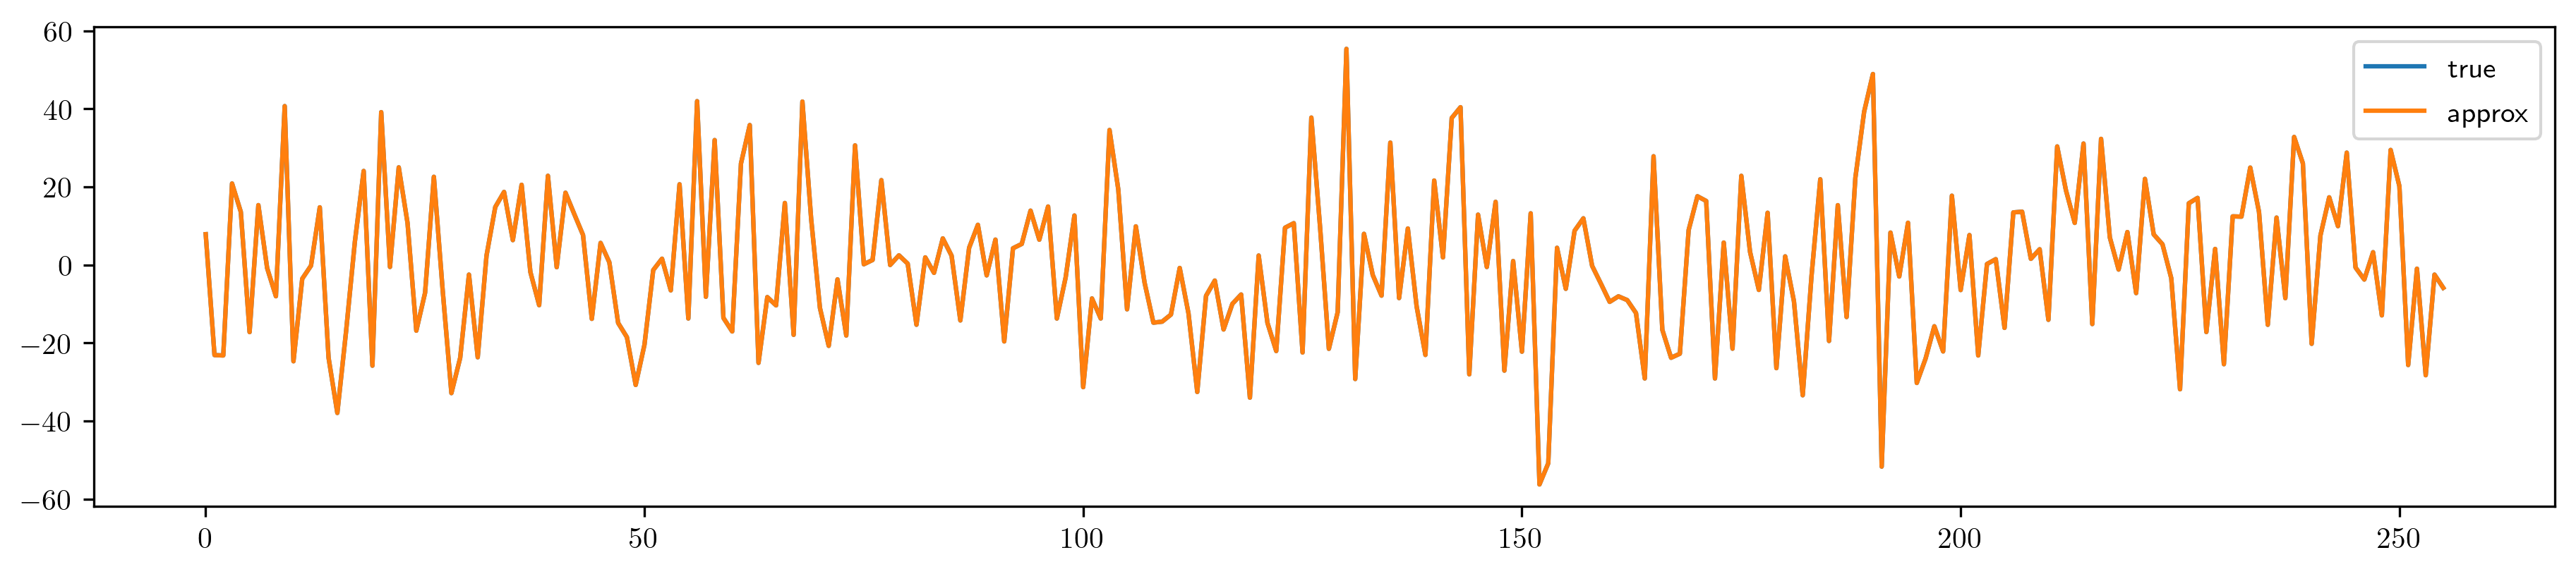

In [129]:
image = np.random.uniform(-1, 1, (1, 8, 8, 64))

a = model_svd.layers[10](model_svd.layers[9](model_svd.layers[8](model_svd.layers[7](image)))).numpy().flatten()
b = M_b @ (image.transpose((0, 3, 1, 2))).flatten() + b_b

plt.figure(figsize=(15, 3))
plt.plot(a, label='true')
plt.plot(b, label='approx')
plt.legend()
plt.show()


In [176]:
save_data(model_svd, 'CIFAR-SVD', testX, linear=[(M_a.transpose(), b_a, 2, 4), (M_b.transpose(), b_b, 7, 11)])

(5, 2)


In [ ]:
model_test = Sequential(
    model_svd.layers[0:11]
)

a = model_test(testX[8:8+1])[0].numpy().flatten()
b = np.load('256outputs.npy')

plt.figure(figsize=(15, 3))
plt.plot(a - b_b, label='true')
plt.plot(b[:256], label='approx')

plt.legend()
plt.show()


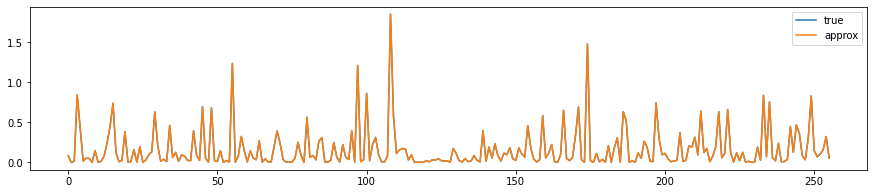

In [591]:
model_test = Sequential(
    model_svd.layers[0:12]
)

a = model_test(testX[8:8+1])[0].numpy().flatten()
b = np.load('256inputs.npy')

plt.figure(figsize=(15, 3))
plt.plot(a, label='true')
plt.plot(b[:256], label='approx')

plt.legend()
plt.show()

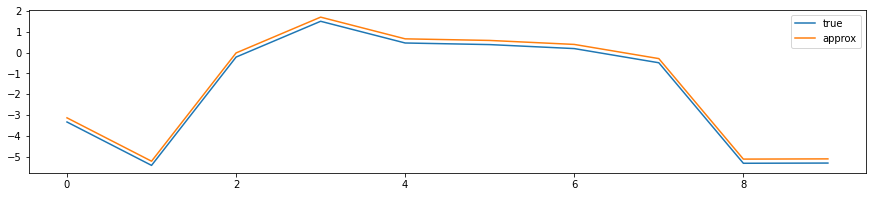

In [595]:
model_test = Sequential(
    model_svd.layers
)

model_test.layers[-1].activation = identity

a = model_test(testX[8:8+1])[0].numpy().flatten()
b = np.load('10outputs.npy')

plt.figure(figsize=(15, 3))
plt.plot(a, label='true')
plt.plot(b[:10] + .2, label='approx')

plt.legend()
plt.show()